In [49]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from pathlib import Path
import pandas as pd
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from scipy.ndimage import gaussian_filter1d
from matplotlib.gridspec import GridSpec
from scipy.stats import gamma
from scipy.signal import convolve2d

In [2]:
# base_dir = r'C:\Users\srini\Documents\GitHub\Paton-Lab--Summer-2024\Splinter' # Champalimaud PC dir

base_dir = r'/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter' # Srinidhi Mac dir
session = 0 # Change based on which trial you want
date = sorted(os.listdir(base_dir))[session + 1]
path = os.path.join(base_dir, date)
os.chdir(path)
print(path)

log_df = pd.read_csv('LogDf.csv')
session_df = pd.read_csv('SessionDf.csv')

log_data = log_df.to_dict(orient= 'dict')
session_data = session_df.to_dict(orient= 'dict')

spike_times = np.load('spiketimes.npy', allow_pickle=True)
NUM_NEURONS = spike_times.shape[0]
NUM_STIMS = 8

/Users/srinidhienaidu/Downloads/GitHub/Paton-Lab--Summer-2024/Splinter/2016-07-27


In [3]:
print('Date: ', sorted(os.listdir(base_dir))[session + 1])
print('Number Neurons: ', NUM_NEURONS)
print('Log Keys: ', log_data.keys())
print('Session Keys: ', session_data.keys())

Date:  2016-07-27
Number Neurons:  19
Log Keys:  dict_keys(['Unnamed: 0', 't', 'name', 'var', 'value'])
Session Keys:  dict_keys(['Unnamed: 0', 'chosen_side', 'chosen_interval', 'correct_side', 'interval_category', 'has_choice', 'this_interval', 'outcome', 'init_port', 'choice_rt', 't_on', 't_off', 't'])


In [4]:
def set_spines_invisible(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def set_grid_invisible(ax):
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

def common_label(fig, xlabel, ylabel):
    """Put a common `xlabel` and `ylabel` on the figure `fig`.
    
    Args:
        - fig (plt.figure)
        - xlabel (str)
        - ylabel (str)
    """
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [5]:
def remove_nans(arr):
    return [x for x in arr if not math.isnan(x)]

def nan_idx(data):
    nan_idx = []
    for index in data:
        if isinstance(data[index], float):
            nan_idx.append(index)
    return nan_idx

def list_to_sorted_arr(og_list, list_to_sort_by):
    arr = np.array(og_list)
    return arr[list_to_sort_by]

for cell in np.arange(NUM_NEURONS):
    spike_times[cell] = remove_nans(spike_times[cell])  


In [6]:
stim_onset_t_pre = []
stim_offset_t = []

for index in np.arange(len(log_data['t'])):

    time = log_data['t'][index]
    name = log_data['name'][index]

    if name == 'STIM_ONSET_EVENT':
        stim_onset_t_pre.append(time)
    elif name == 'STIM_OFFSET_EVENT':
        stim_offset_t.append(time)  
    
NUM_TRIALS = len(stim_offset_t)
trial_num = np.arange(0, len(stim_onset_t_pre), 1)

code for plotting raw rasters, before sorting by stim_duration

In [7]:
# window = [-2000,4000]
# n_trials = len(stim_onset_t)
# neuron = 13
# all_spikes_neuron = []
# all_trial_nums = []
# for idx, trial in enumerate(original_indices):
#     # print(trial)
#     # print(stim_onset_t[trial])
#     aligned_spikes = np.array(spike_times[neuron]) - stim_onset_t[trial]
#     # print(aligned_spikes)
#     trial_index_spikes = np.intersect1d(np.where(aligned_spikes<window[1])[0],np.where(aligned_spikes>window[0])[0])
#     all_spikes_neuron.extend(aligned_spikes[trial_index_spikes])
#     n_spikes = len(trial_index_spikes)
#     all_trial_nums.extend([trial]*n_spikes)
# print(all_trial_nums)
# plt.figure()
# plt.scatter(all_spikes_neuron, all_trial_nums,s=0.1)
# plt.ylabel("Trial number")
# plt.xlabel("Time since stimulus onset (ms)")
# plt.title(f"Neuron {neuron}")
# plt.axvline(x=0,color="k",ls="--")
# plt.show()

In [8]:
choice = session_data['chosen_side']
no_choice_idx = nan_idx(choice)

stim_onset_t = [value for index, value in enumerate(stim_onset_t_pre) if index not in no_choice_idx]
og_trial_num = [value for index, value in enumerate(trial_num) if index not in no_choice_idx]

general_trial_num = np.arange(0, len(stim_onset_t), 1)

int_durations = np.zeros((NUM_TRIALS))
choice_rt = []

for idx, val in enumerate(og_trial_num):

    int_durations[idx] = (session_data['this_interval'][val])
    choice_rt.append(session_data['choice_rt'][val])


sort_by_dur_idx = np.argsort(int_durations)

sorted_int_durations = int_durations[sort_by_dur_idx]
new_sorted_trials = general_trial_num[sort_by_dur_idx]

dur_vals = [600, 1050, 1260, 1380, 1620, 1740, 1950, 2400]

# stim_offset_t = list_to_sorted_arr(stim_offset_t_pre, sort_by_dur_idx)

In [9]:
n_sorted_init = []
n_init_dur = []

s_sorted_init = []
s_init_dur = []

init_port = session_data['init_port']

for dur, val in enumerate(new_sorted_trials):
    if init_port[val] == 'N':
        n_sorted_init.append(val)
        n_init_dur.append(sorted_int_durations[dur])

    elif init_port[val] == 'S':
        s_sorted_init.append(val)
        s_init_dur.append(sorted_int_durations[dur])

n_sorted_init = np.array(n_sorted_init)
s_sorted_init = np.array(s_sorted_init)

Deciding the colors to be used in the plot:

In [10]:
def plot_colors(cmap):
    cmap = plt.get_cmap(cmap)
    points = np.linspace(0, 1, NUM_STIMS + 1)
    colors = []
    for stim in np.arange(NUM_STIMS):
        colors.append(cmap(points[stim + 1]))
    return colors

In [11]:
def counts_and_cumulative(to_count):
    int_counts = Counter(to_count)
    counts = list(int_counts.values())

    cumulative_sum_list = [0]
    running_total = 0
    for value in counts:
        running_total += value
        cumulative_sum_list.append(running_total)

    return counts, cumulative_sum_list

In [12]:
counts, cumulative_sum_list = counts_and_cumulative(sorted_int_durations)
n_counts, n_cumulative_sum = counts_and_cumulative(n_init_dur)
s_counts, s_cumulative_sum = counts_and_cumulative(s_init_dur)


In [13]:
BIN_SIZE = 10
window = [-1000, 8000]
bins = np.arange(window[0], window[1], BIN_SIZE) 
num_neurons = NUM_NEURONS

In [14]:
def bin_values_by_range(values, start_values, end_values):
    bins = []
    for start, end in zip(start_values, end_values):
        mask = (values >= start) & (values < end)
        bins.append(len(values[mask]))
        bin_array = np.array(bins)
    
    return bin_array

In [15]:
def sum_over_trial_bins(stacked_bin_array, cumulative_sum_list):
    for_trial_sums = []
    raw_bins = []
    for stim_dur in np.arange(NUM_STIMS):
        bin_start = cumulative_sum_list[stim_dur]
        bin_end = cumulative_sum_list[stim_dur + 1] 
        summed_counts = (stacked_bin_array[:][bin_start:bin_end])
        raw_bins.append(summed_counts)
        normalized_counts = summed_counts / BIN_SIZE * 1000
        mean_counts = np.mean(normalized_counts, axis = 0)
        for_trial_sums.append(mean_counts)

    sum_over_trial_bins = np.vstack(for_trial_sums)
    raw_bin_arr = np.vstack(raw_bins)

    return raw_bin_arr, sum_over_trial_bins


In [16]:
def rasters_and_psths(color, data, data_points, num_neurons, window, BIN_SIZE, new_sorted_trials, cumulative_sum_list):
    COND_NUM_TRIALS = len(new_sorted_trials)
    psth_colors = plot_colors(cmap = color)
    cmap = plt.get_cmap(color)
    norm = mcolors.Normalize(vmin=600, vmax=2400)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    full_spikes_neuron = []
    full_trial_nums = []
    full_summed_over_bins = []
    full_raw_bins = []
    full_cond_spike_times = []
    for neuron in np.arange(num_neurons):


        bins = np.arange(window[0], window[1], BIN_SIZE)

        all_spikes_neuron = []
        all_trial_nums = []
        
        binned_counts_array = []
        for_cond_spike_times = []

        
        colored_time_points = np.array(list_to_sorted_arr(stim_offset_t, sort_by_dur_idx) + list_to_sorted_arr(data_points, sort_by_dur_idx) - list_to_sorted_arr(data, sort_by_dur_idx))
        
        for num, val in enumerate(new_sorted_trials):
            # For Raster
            aligned_spikes = np.array(spike_times[neuron]) - data[val]
            trial_index_spikes = np.intersect1d(np.where(aligned_spikes <= window[1])[0], np.where(aligned_spikes > window[0])[0])
            spike_times_in_window = aligned_spikes[trial_index_spikes]
            all_spikes_neuron.extend(spike_times_in_window)
            n_spikes = len(trial_index_spikes)
            all_trial_nums.extend([num] * n_spikes)

            # For PSTH
            binned_counts = bin_values_by_range(values= spike_times_in_window, start_values= bins, end_values= bins + BIN_SIZE)
            binned_counts_array.append(np.array(binned_counts))
            for_cond_spike_times.append(colored_time_points[num])
            # raw_spike_times.append(chunk_spike_times[idx])

        full_spikes_neuron.append(all_spikes_neuron)
        full_trial_nums.append(all_trial_nums)

        stacked_bin_array = np.vstack(binned_counts_array)
        raw_bin, norm_sum_bins = sum_over_trial_bins(stacked_bin_array, cumulative_sum_list)
        full_raw_bins.append(stacked_bin_array)

        full_summed_over_bins.append(norm_sum_bins)
        full_cond_spike_times.append(for_cond_spike_times)
        

    return full_raw_bins, COND_NUM_TRIALS, psth_colors, full_spikes_neuron, full_trial_nums, full_summed_over_bins, full_cond_spike_times


In [17]:
n_onset_raw_bins, N_NUM_TRIALS, n_onset_psth_colors, n_onset_spikes, n_onset_trials, n_onset_summed, n_onset_colored_points = rasters_and_psths(color= 'Reds', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= n_sorted_init, cumulative_sum_list=n_cumulative_sum)
print('N ONSET COMPLETE')
n_offset_raw_bins, N_NUM_TRIALS, n_offset_psth_colors, n_offset_spikes, n_offset_trials, n_offset_summed, n_offset_colored_points = rasters_and_psths(color= 'Reds', data= stim_offset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= n_sorted_init, cumulative_sum_list= n_cumulative_sum)
print('N OFFSET COMPLETE')
s_onset_raw_bins, S_NUM_TRIALS, s_onset_psth_colors, s_onset_spikes, s_onset_trials, s_onset_summed, s_onset_colored_points = rasters_and_psths(color= 'Blues', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= s_sorted_init, cumulative_sum_list= s_cumulative_sum)
print('S ONSET COMPLETE')
s_offset_raw_bins, S_NUM_TRIALS, s_offset_psth_colors, s_offset_spikes, s_offset_trials, s_offset_summed, s_offset_colored_points = rasters_and_psths(color= 'Blues', data= stim_offset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= s_sorted_init, cumulative_sum_list= s_cumulative_sum)
print('S OFFSET COMPLETE')

N ONSET COMPLETE
N OFFSET COMPLETE
S ONSET COMPLETE
S OFFSET COMPLETE


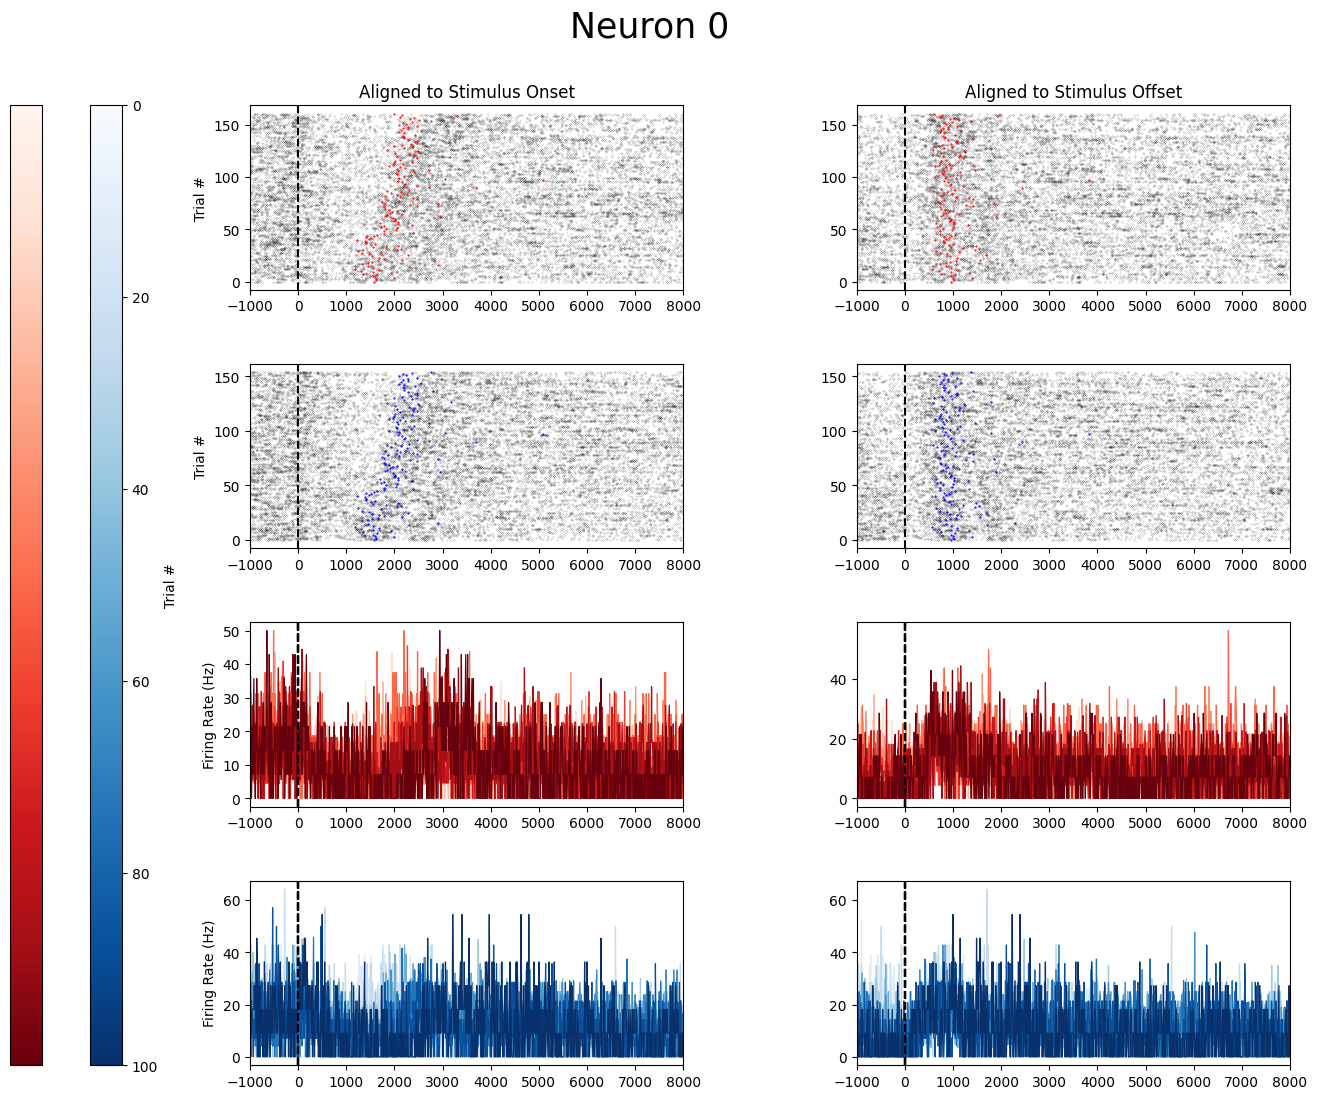

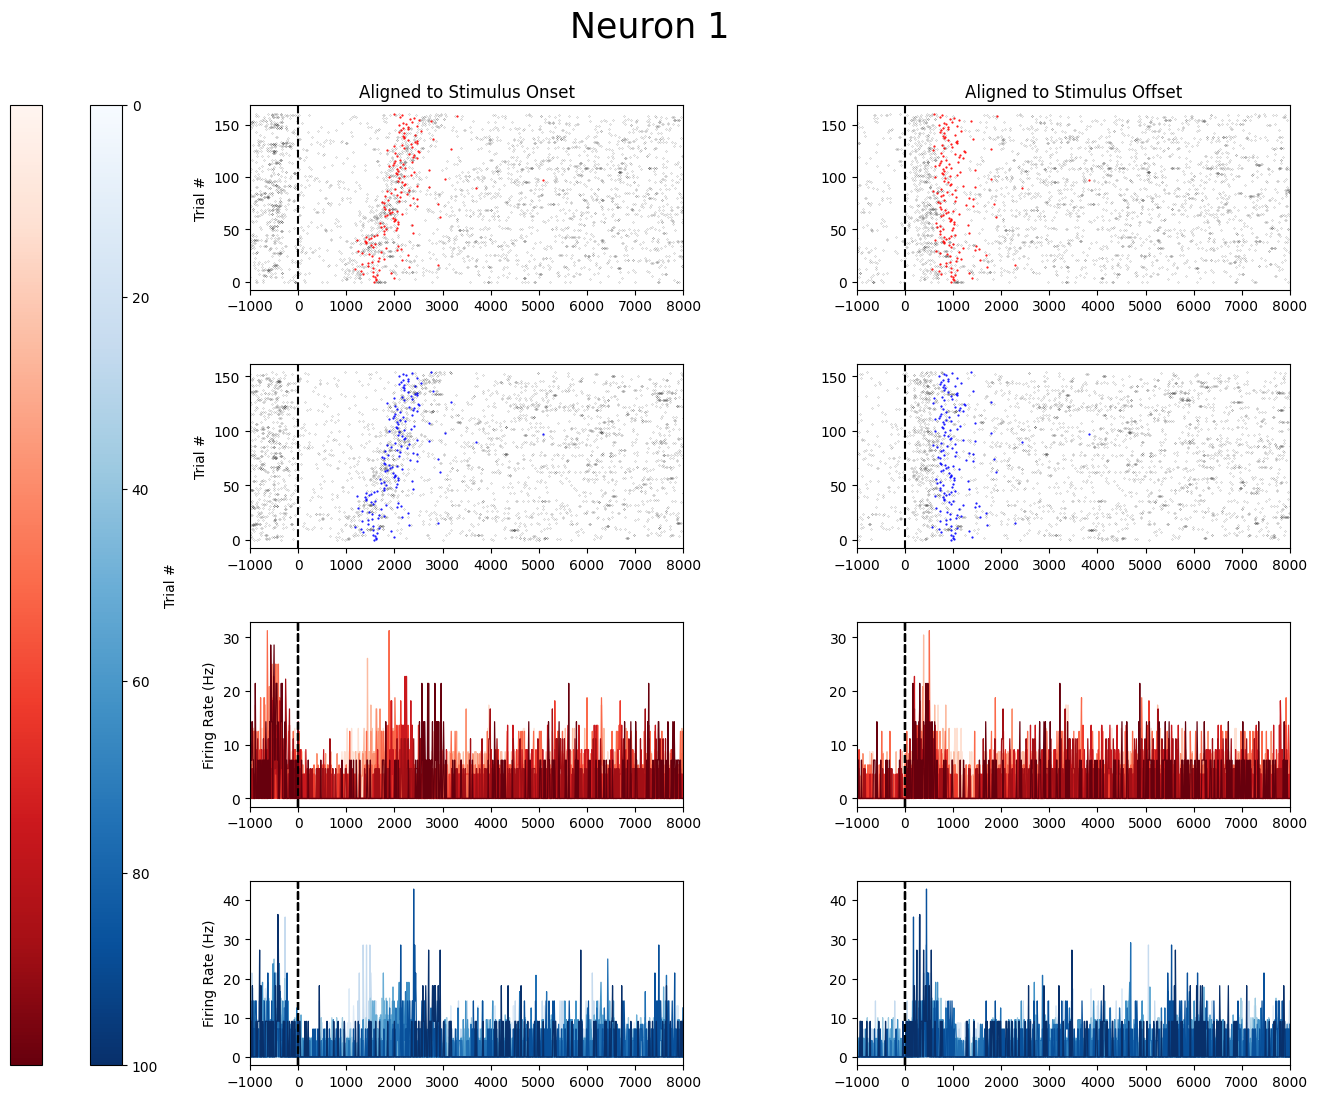

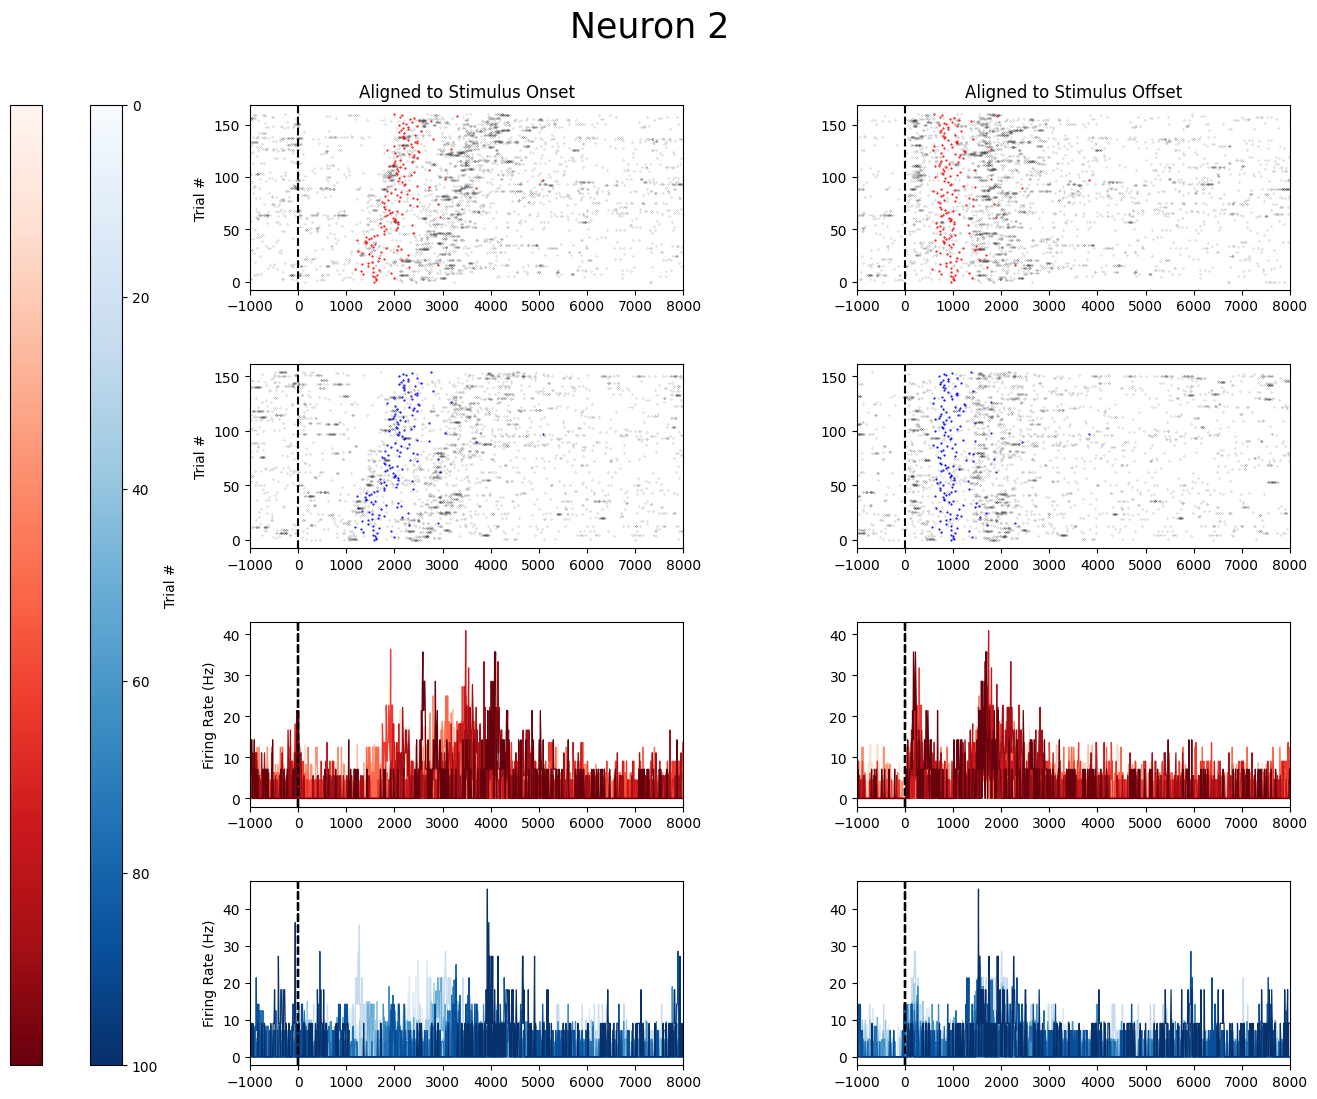

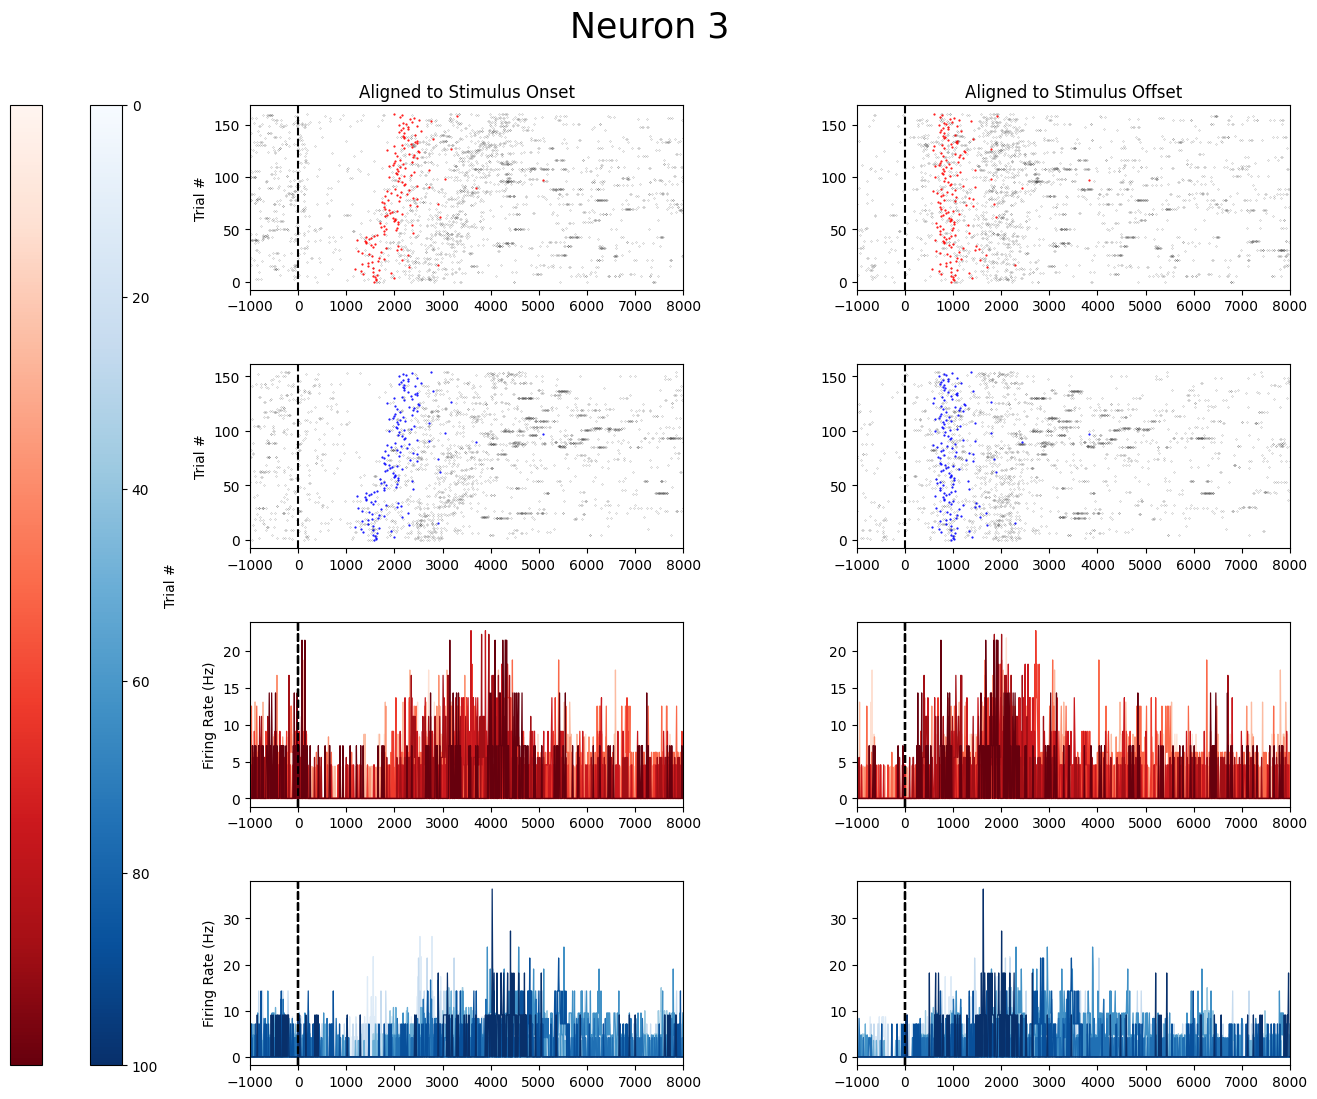

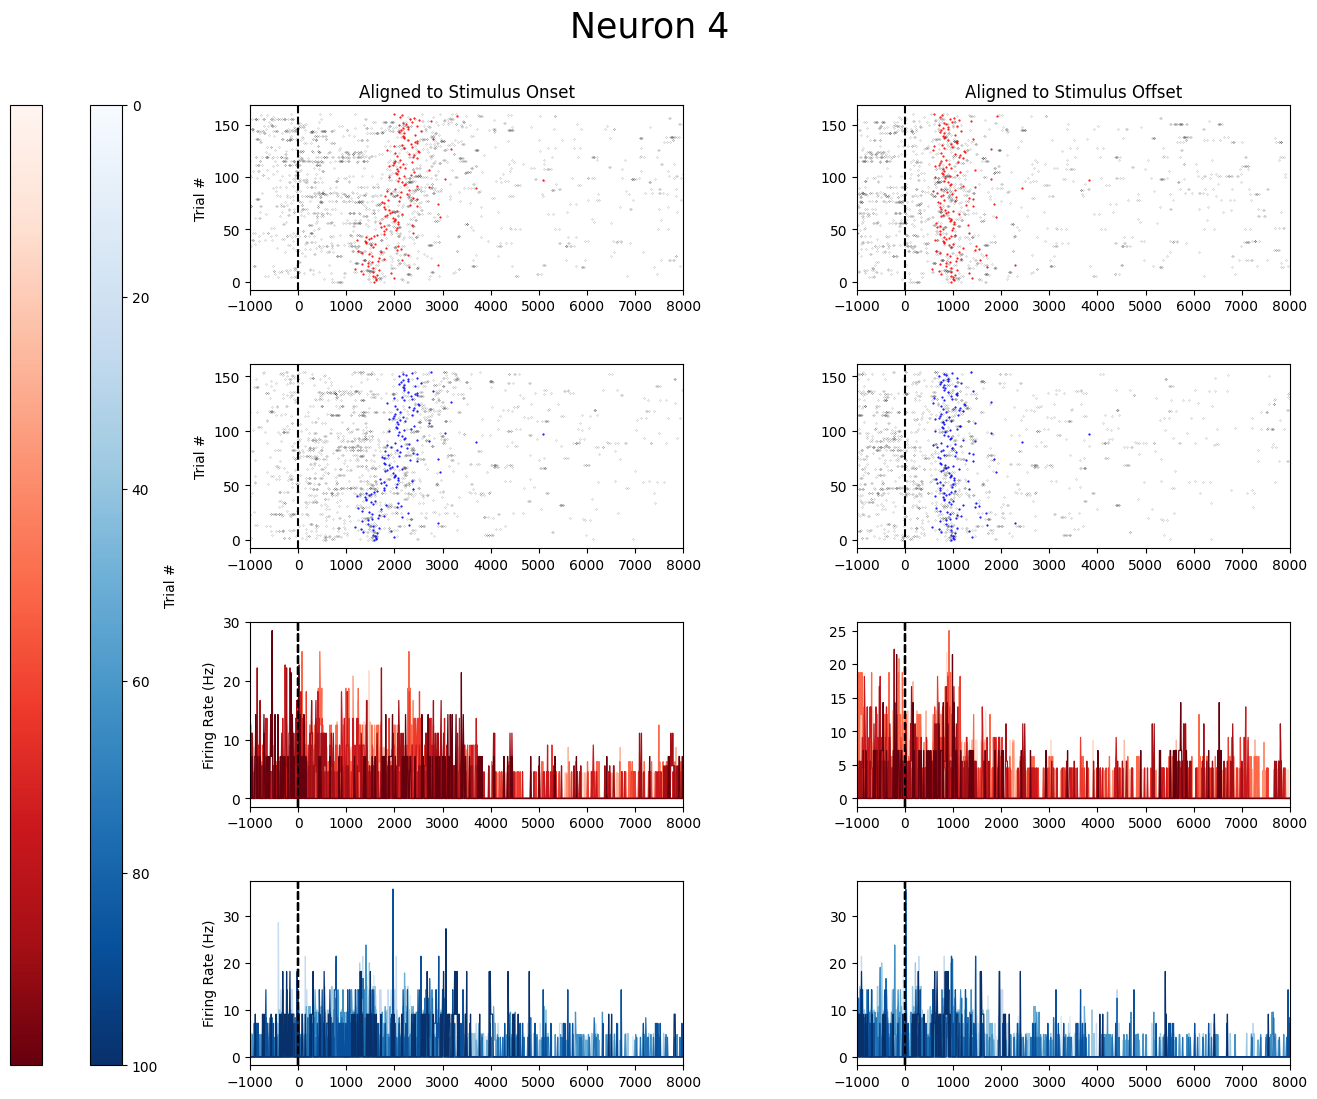

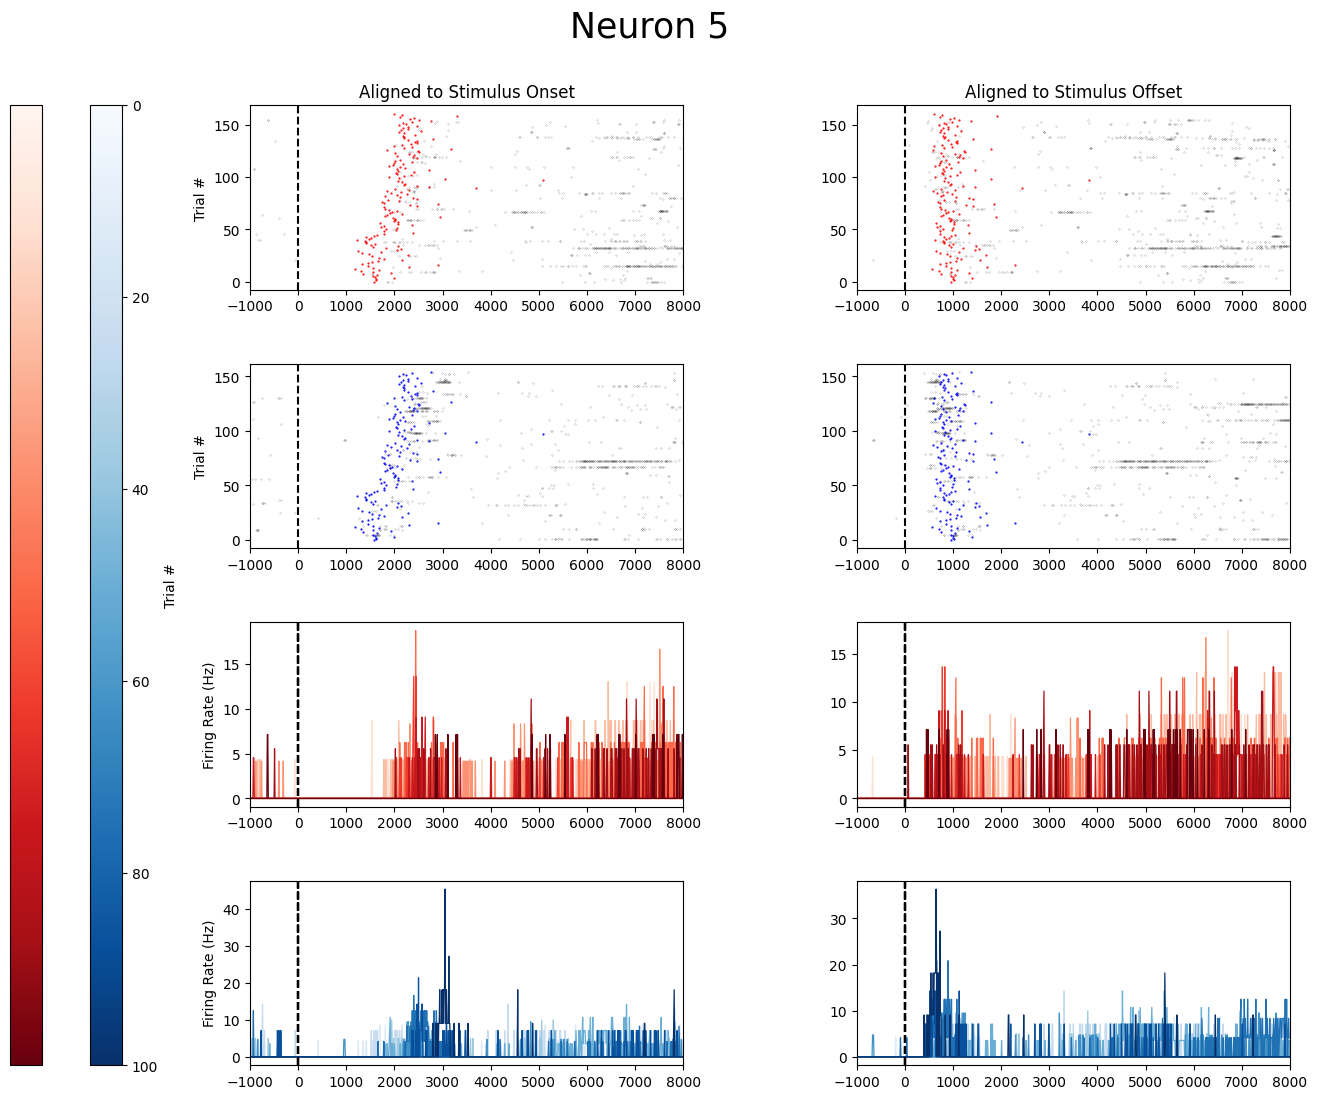

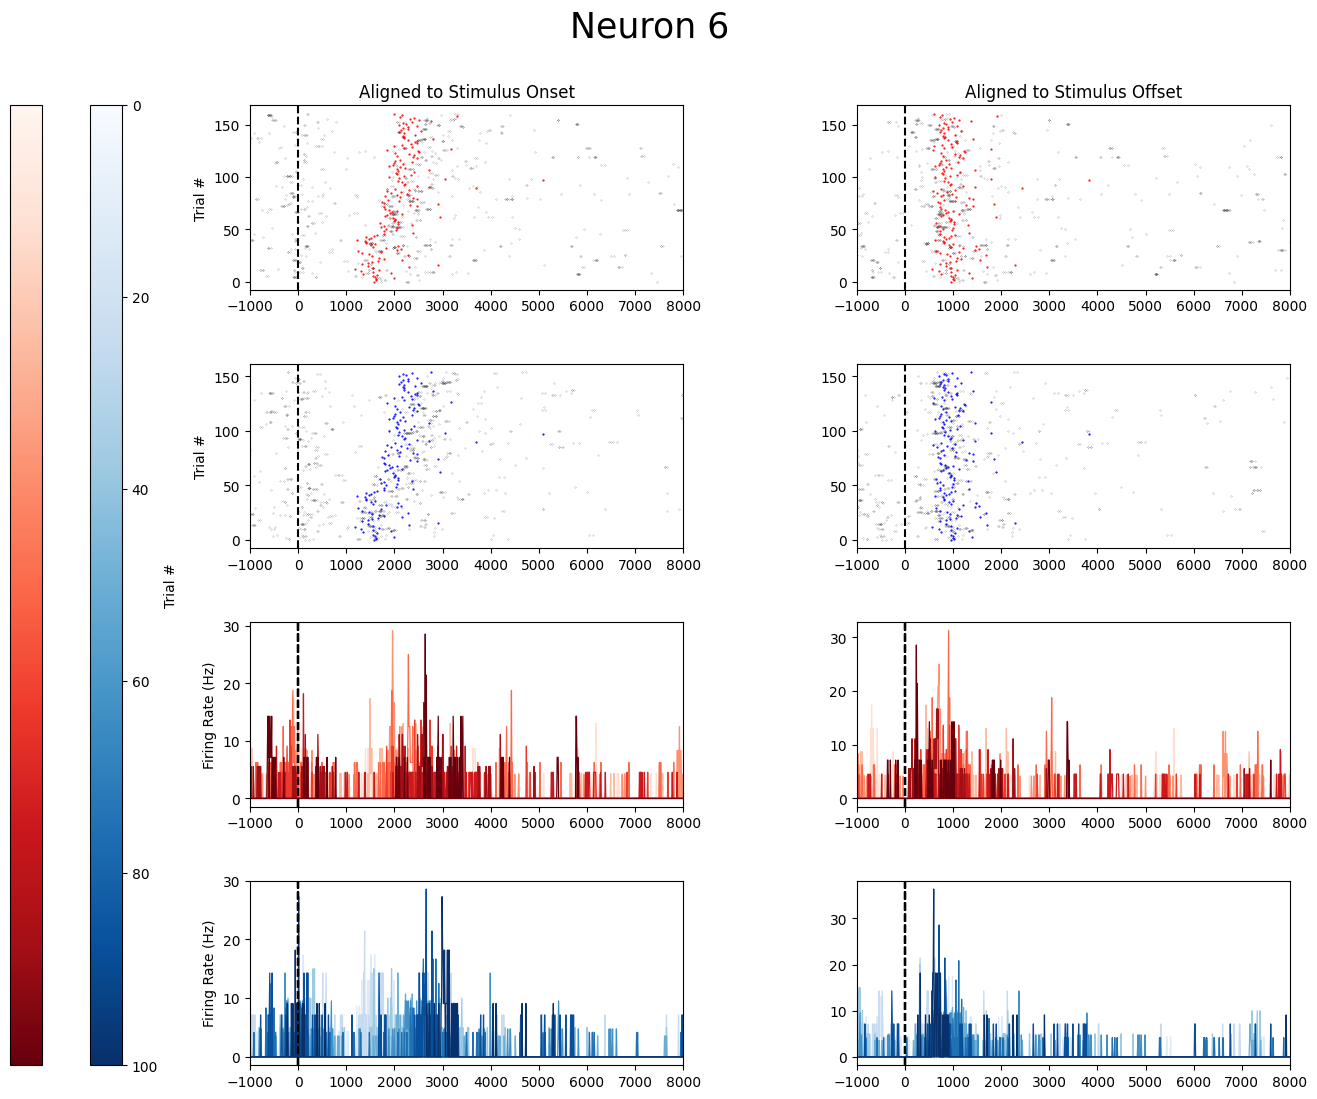

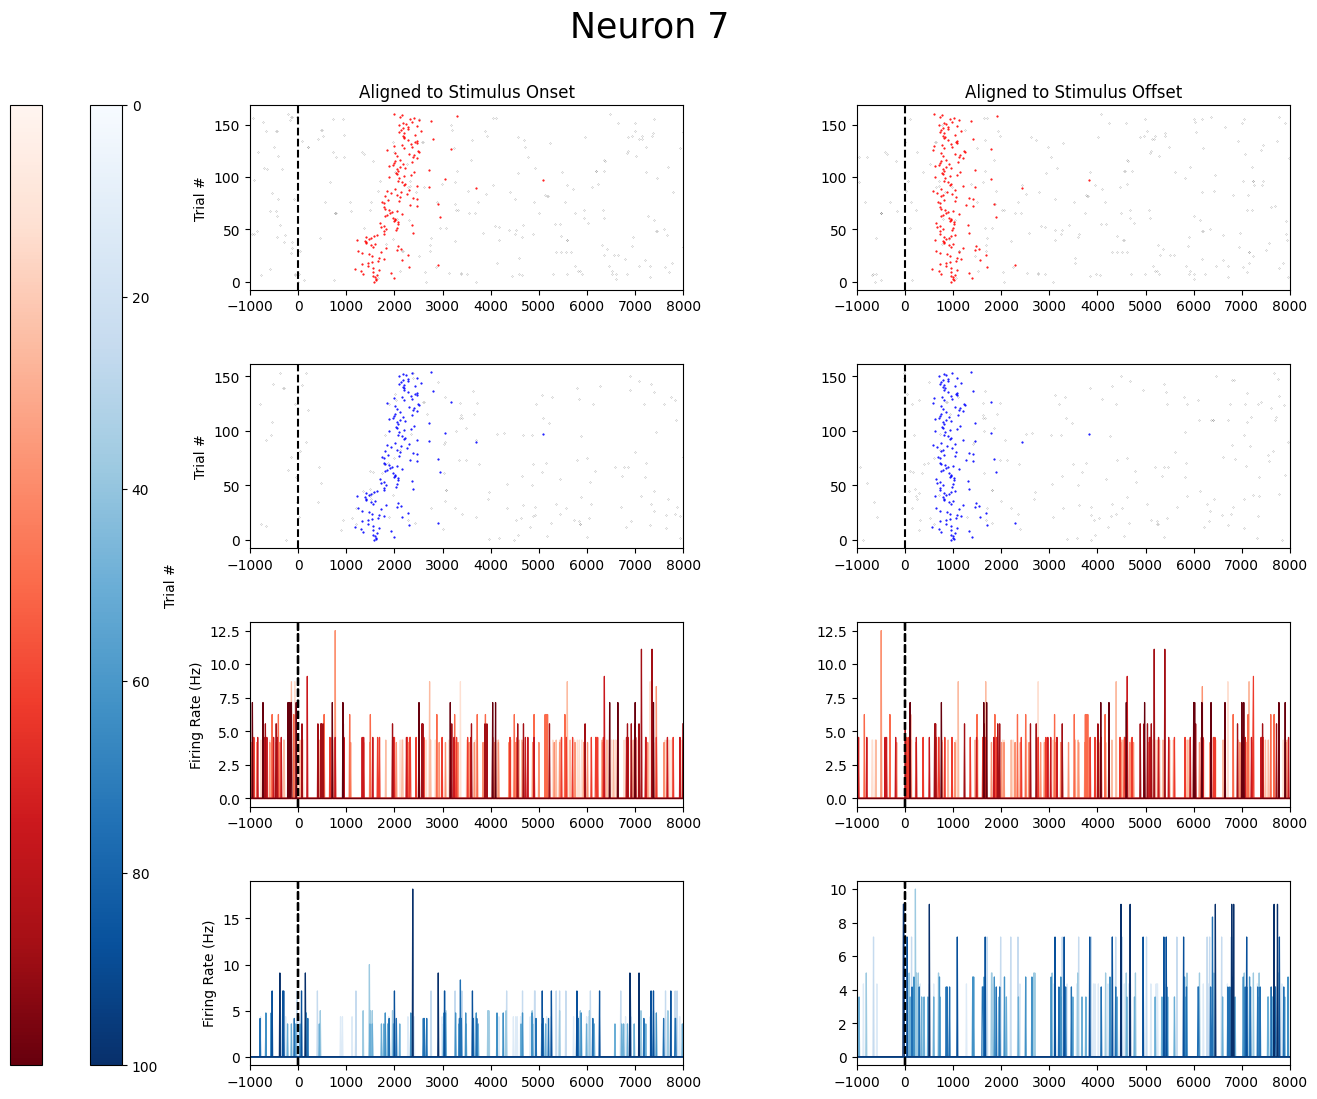

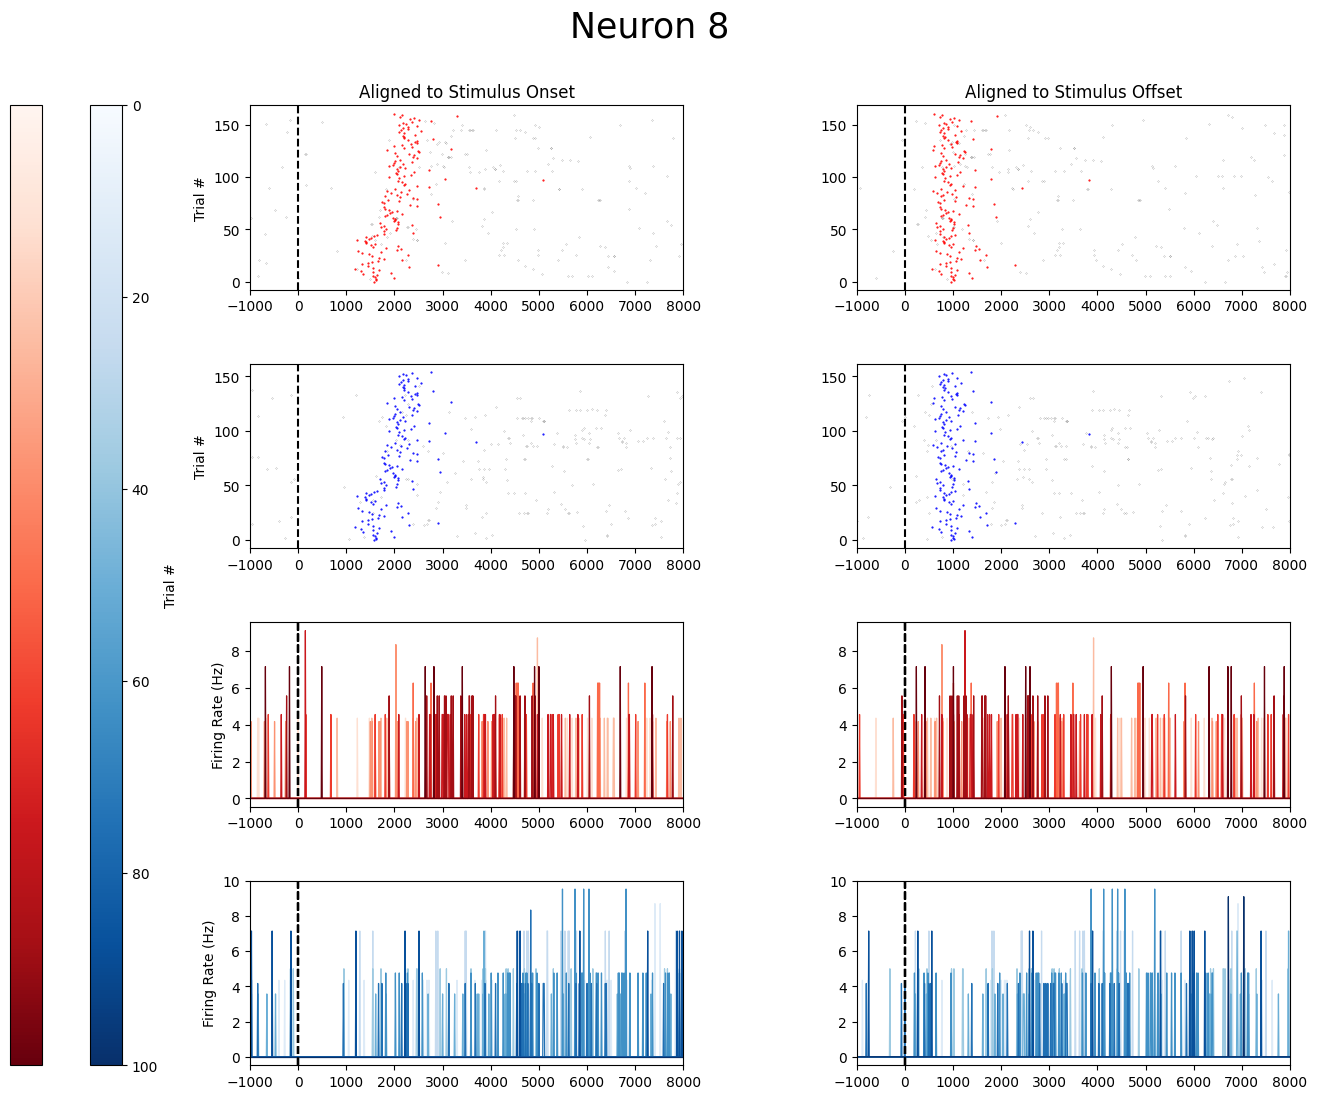

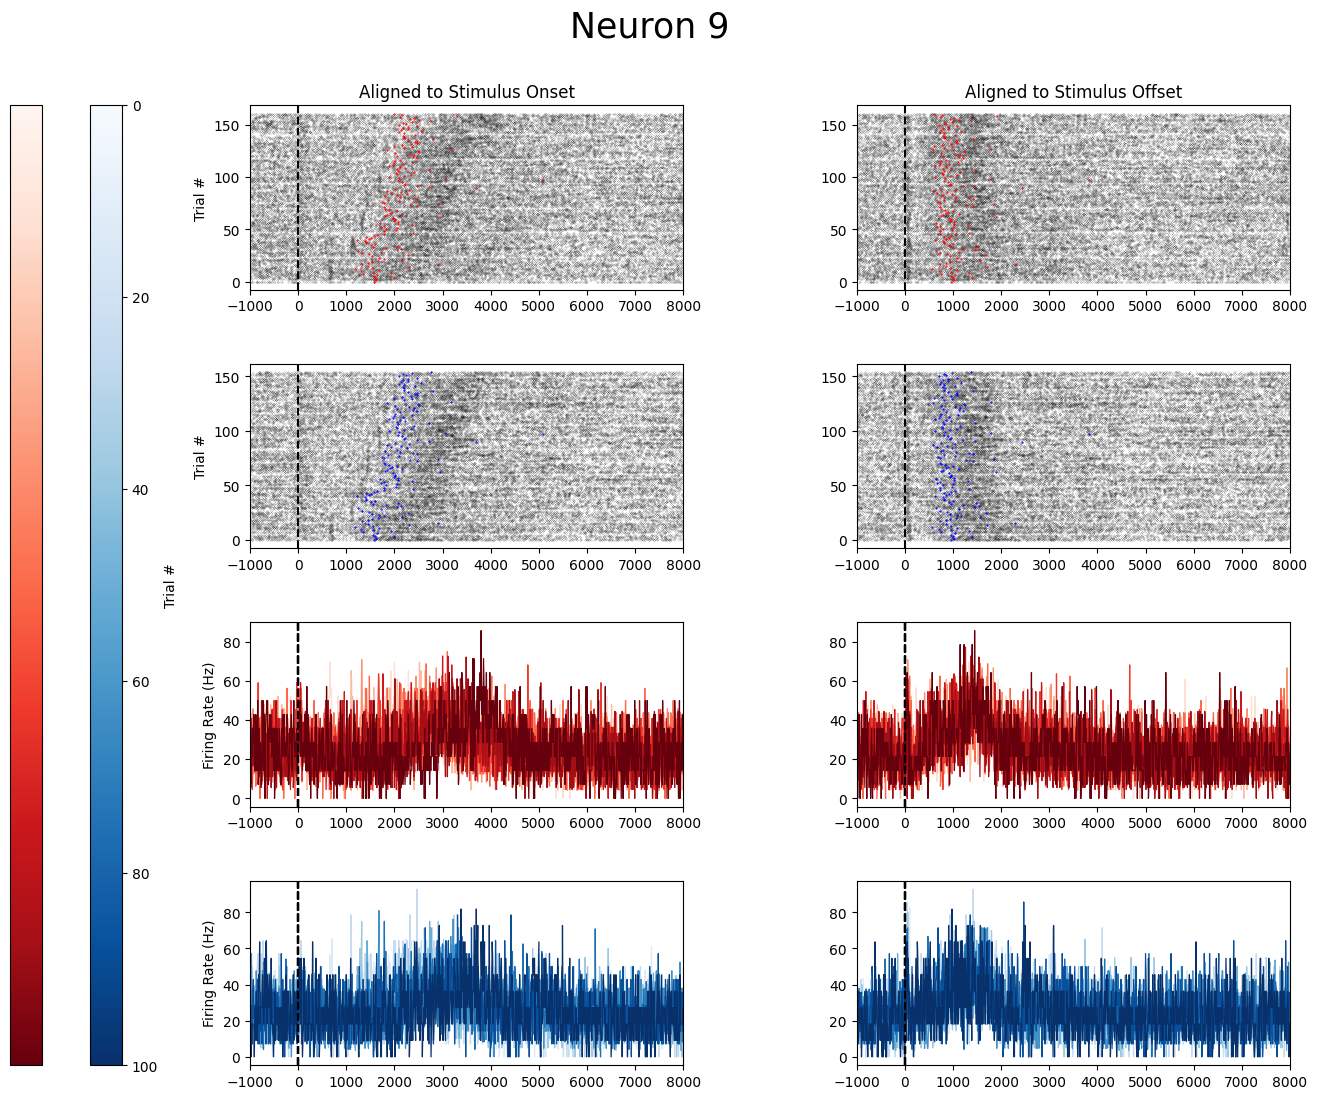

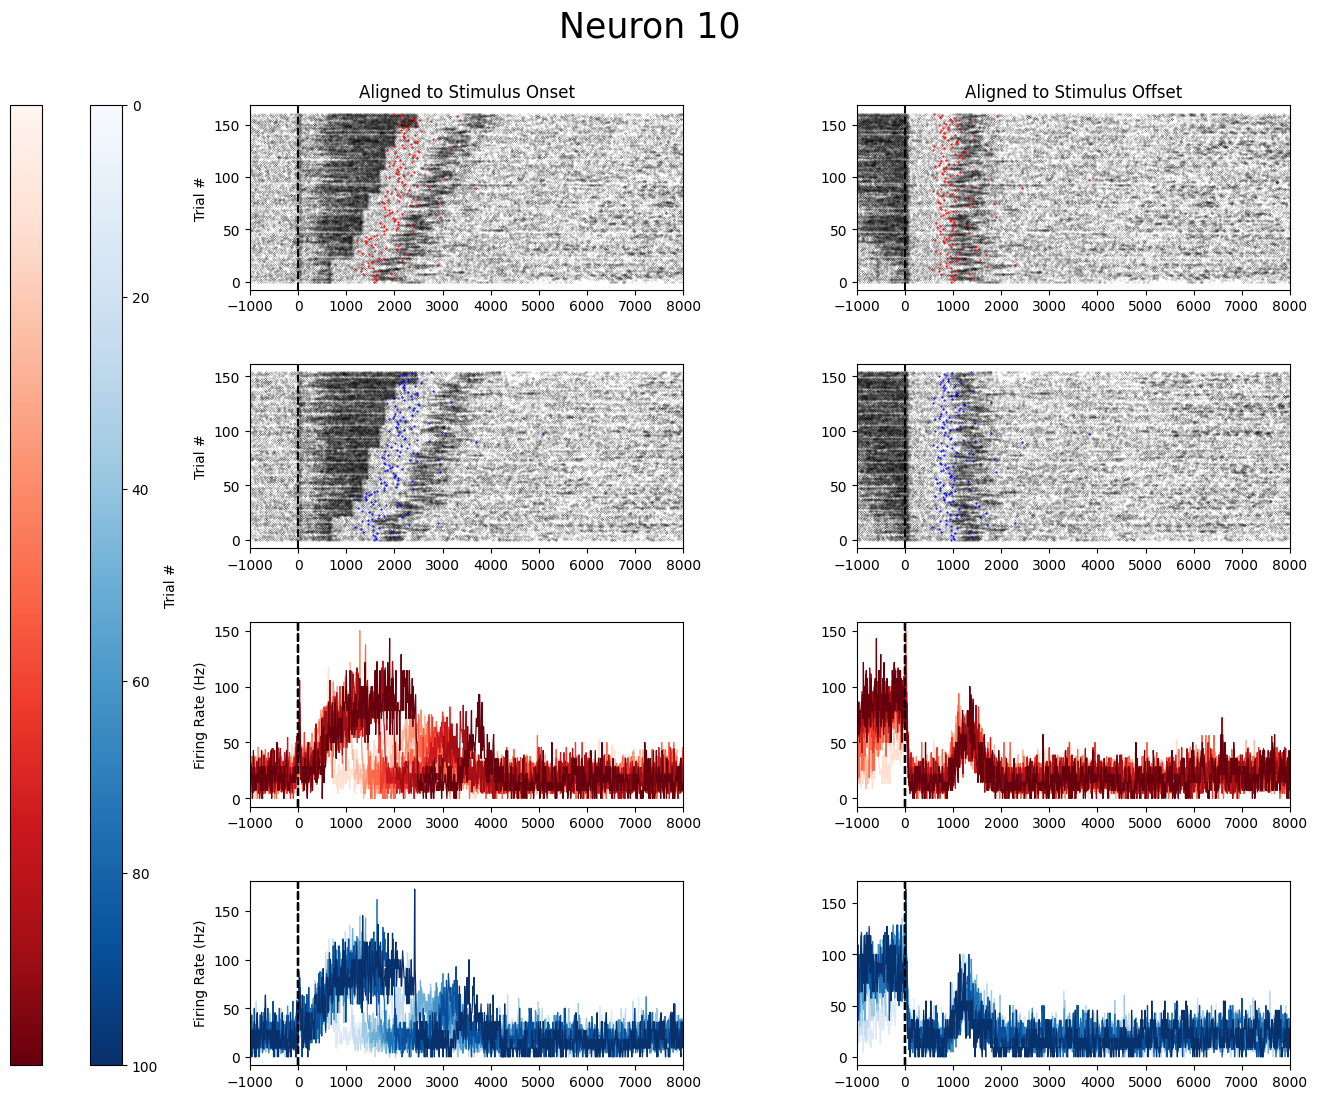

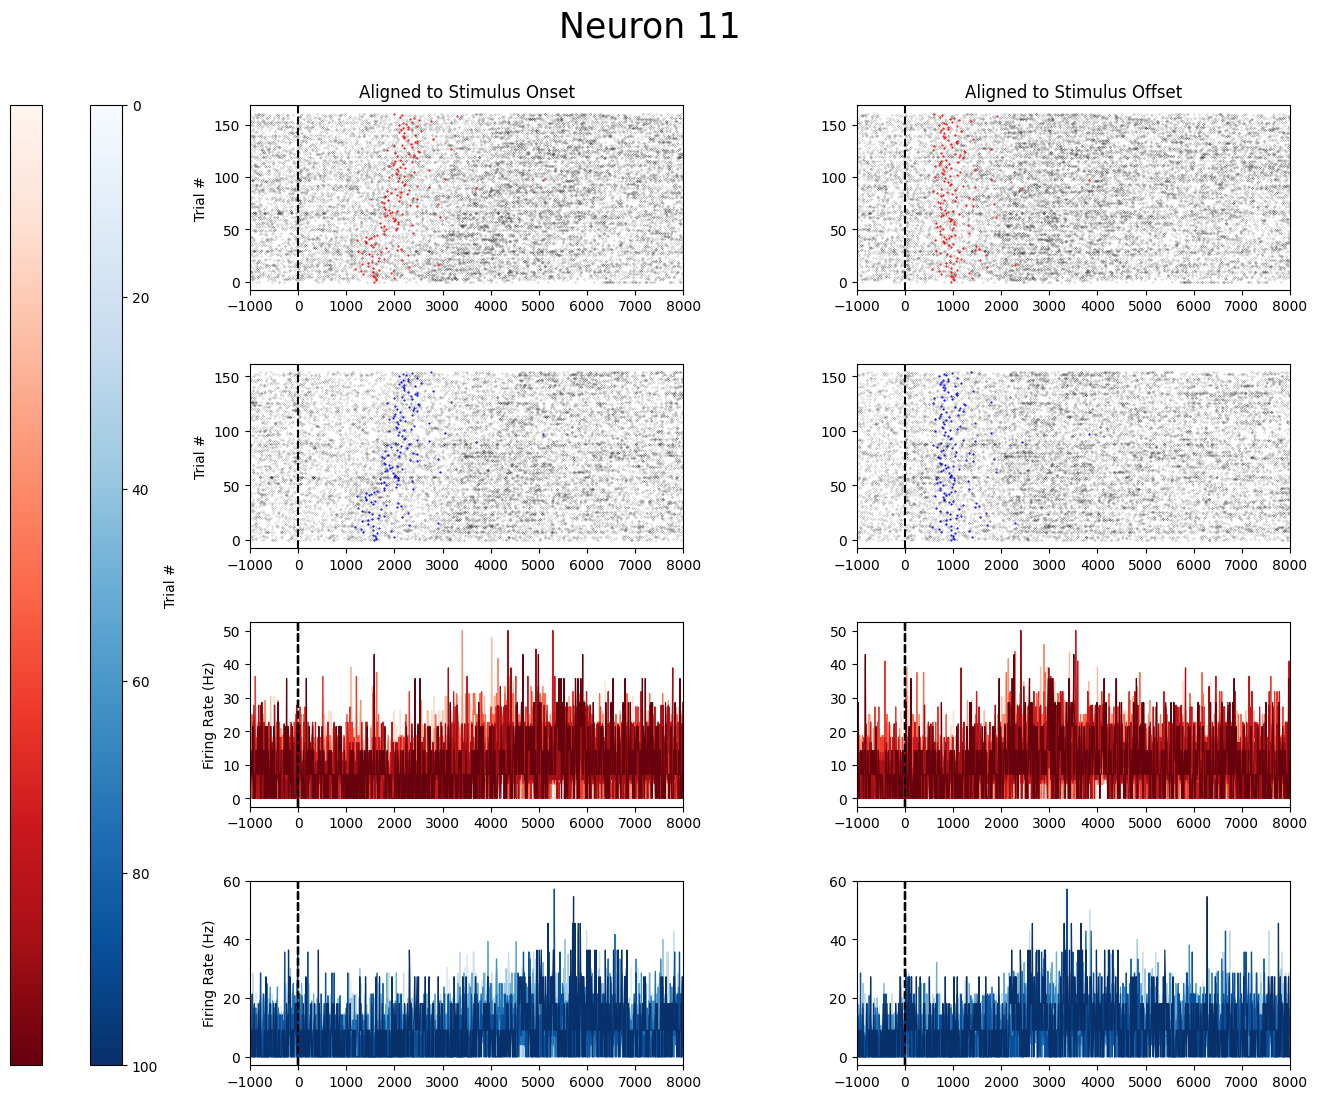

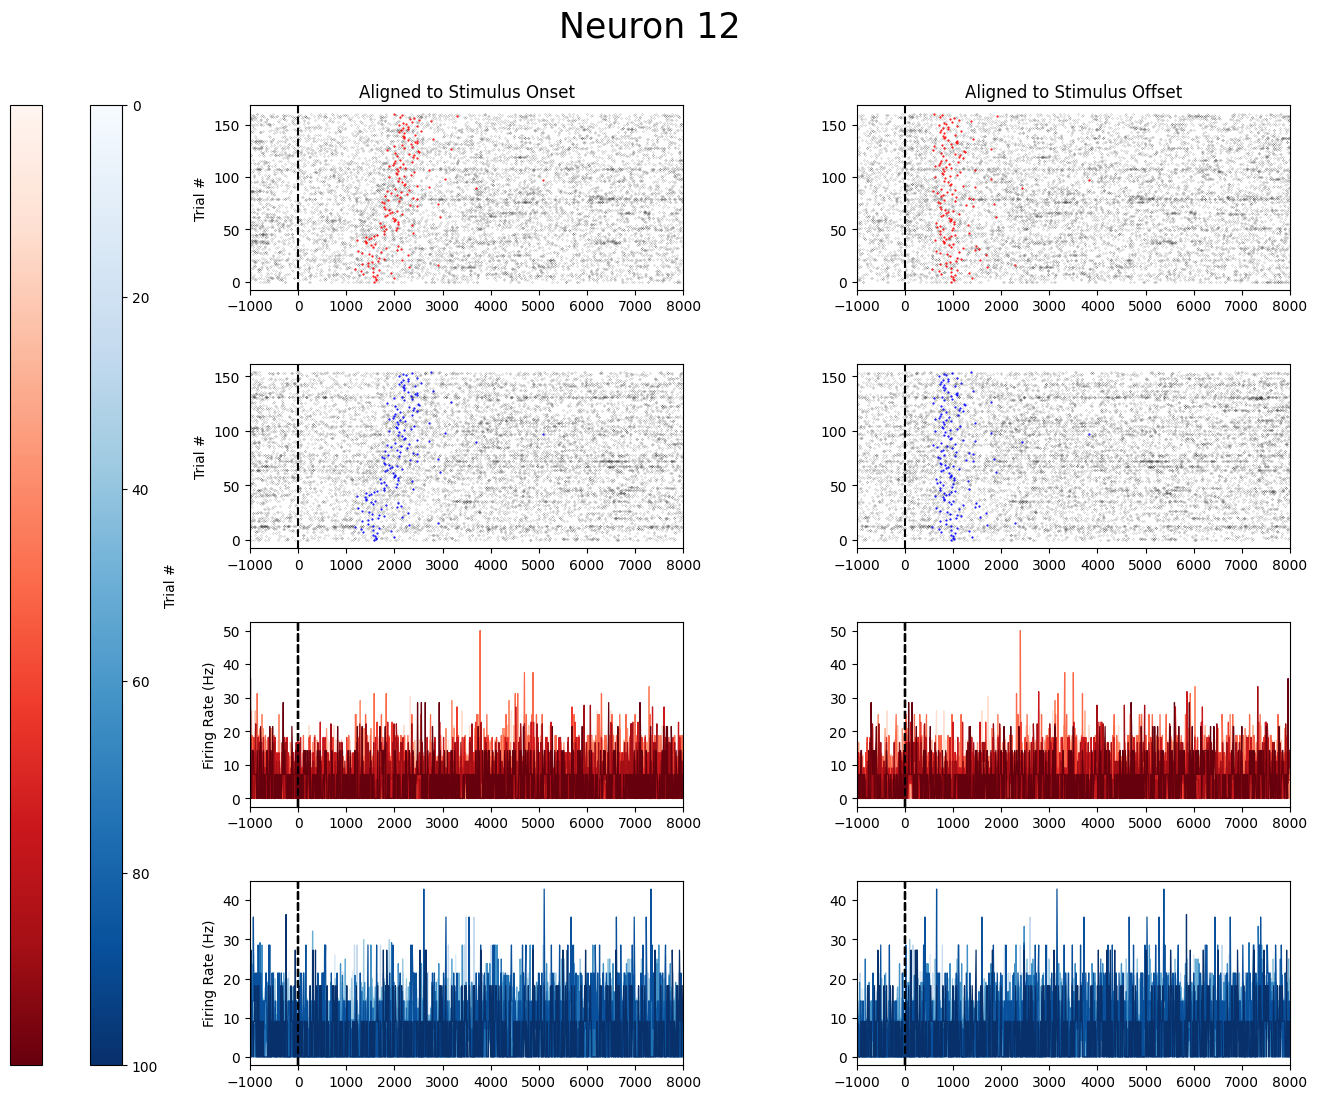

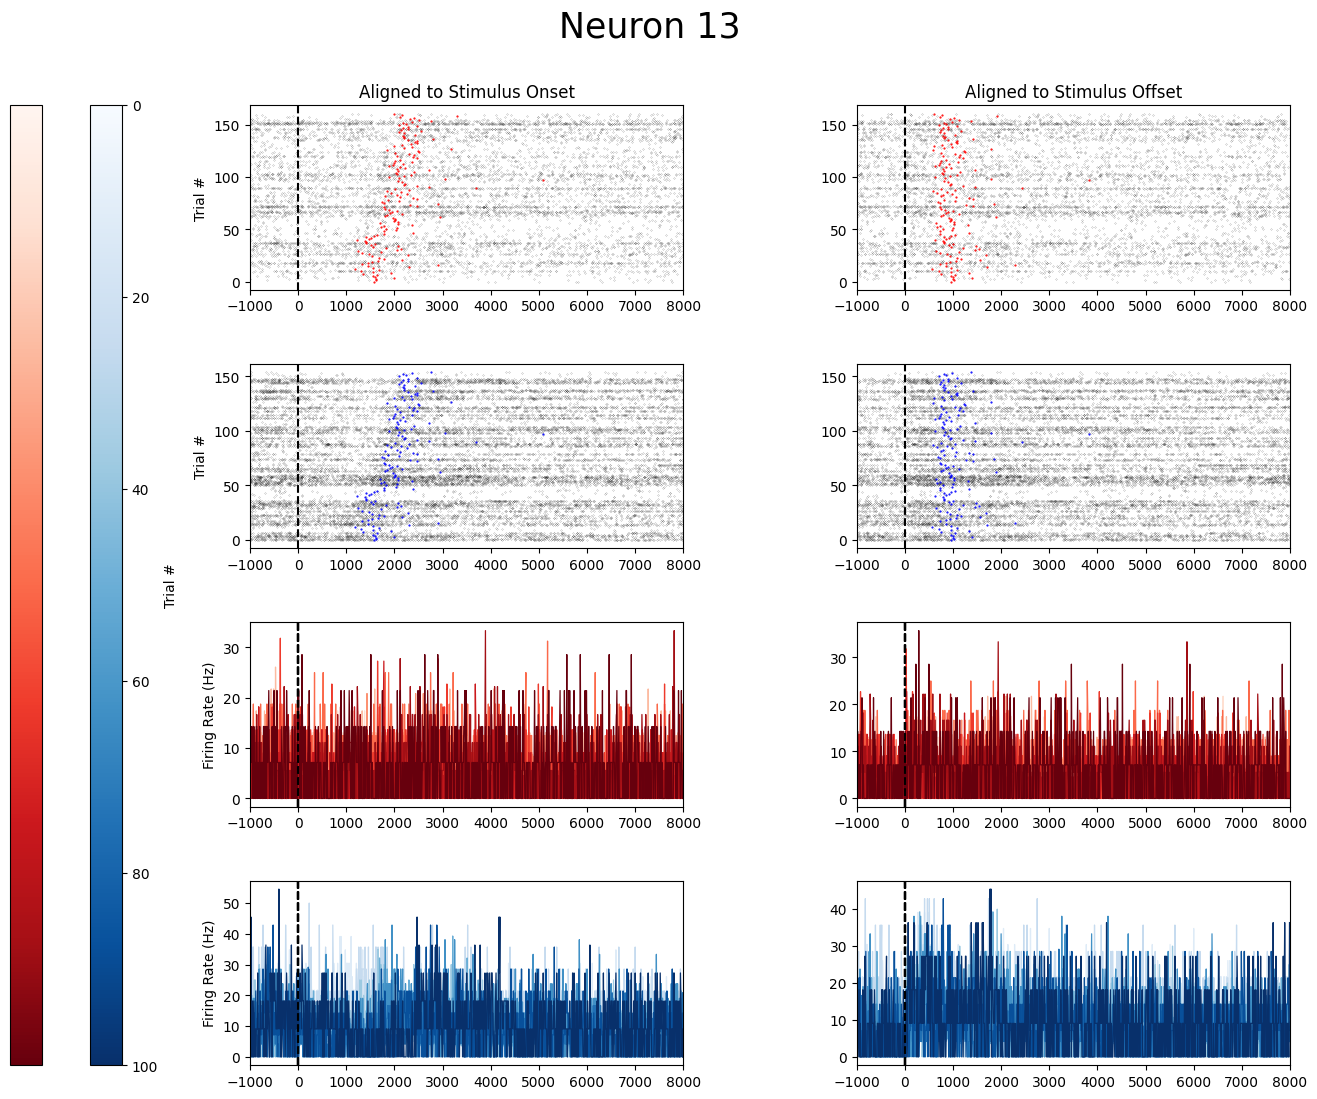

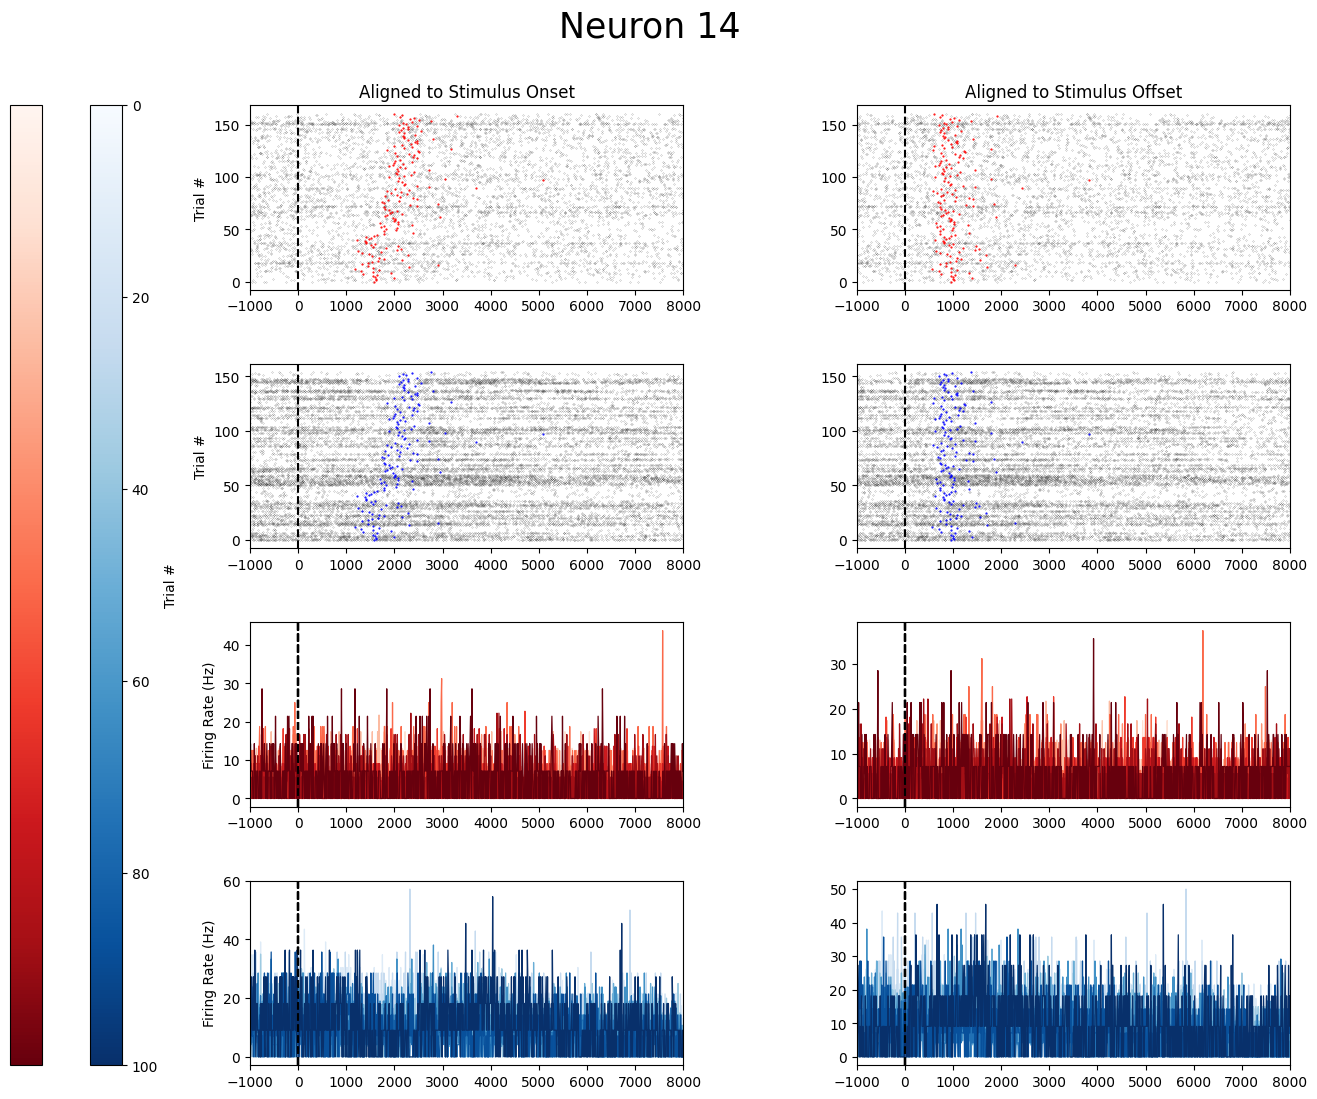

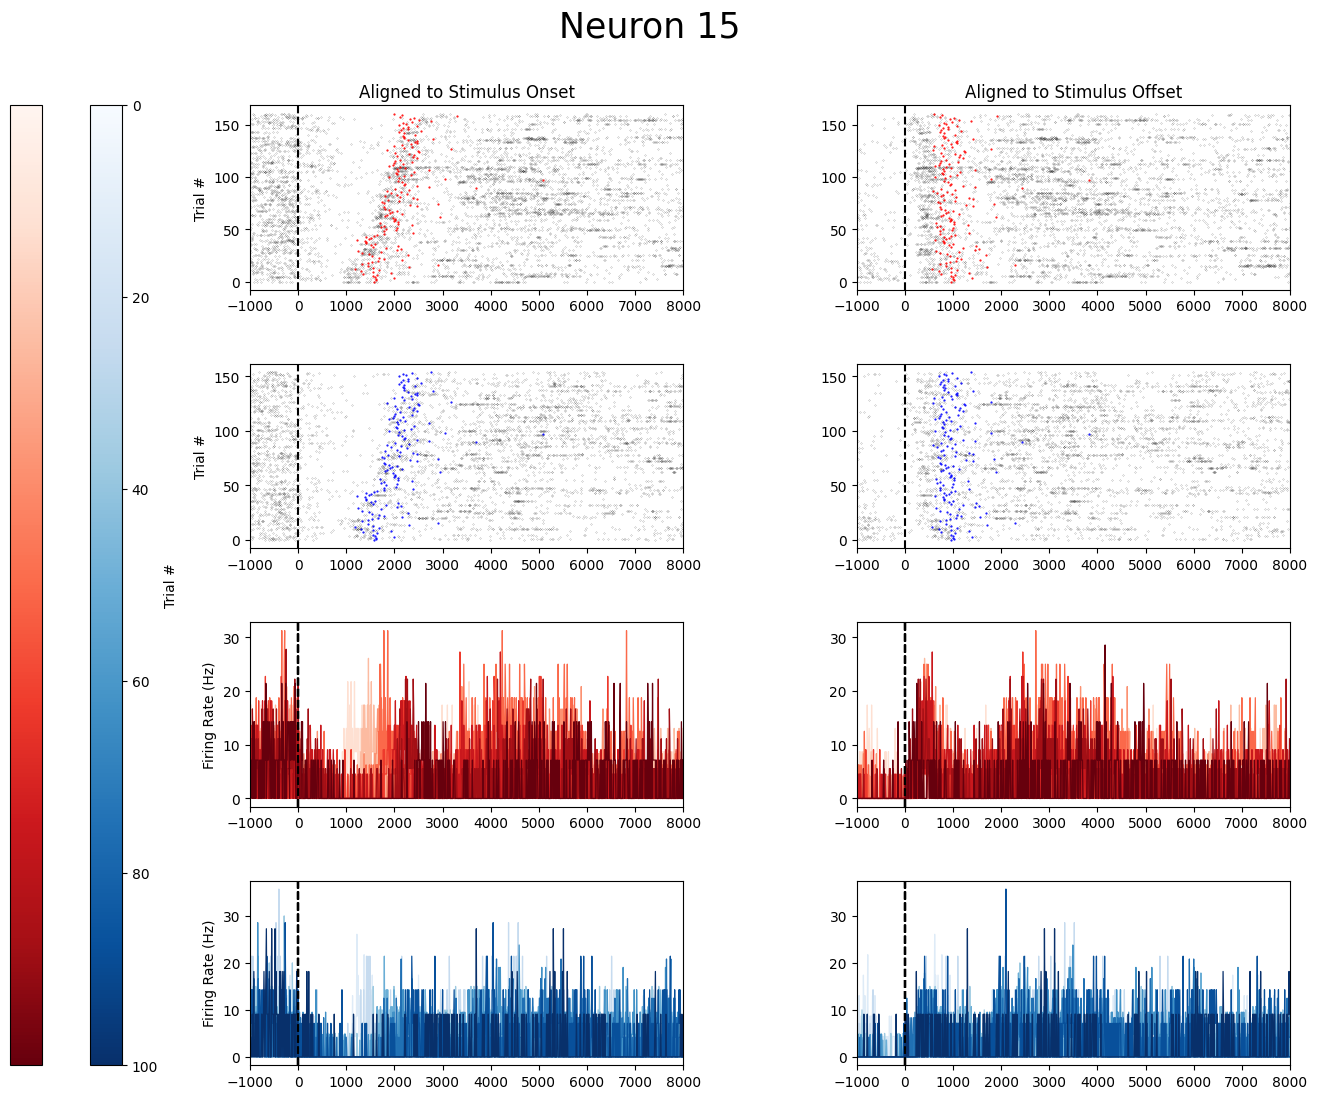

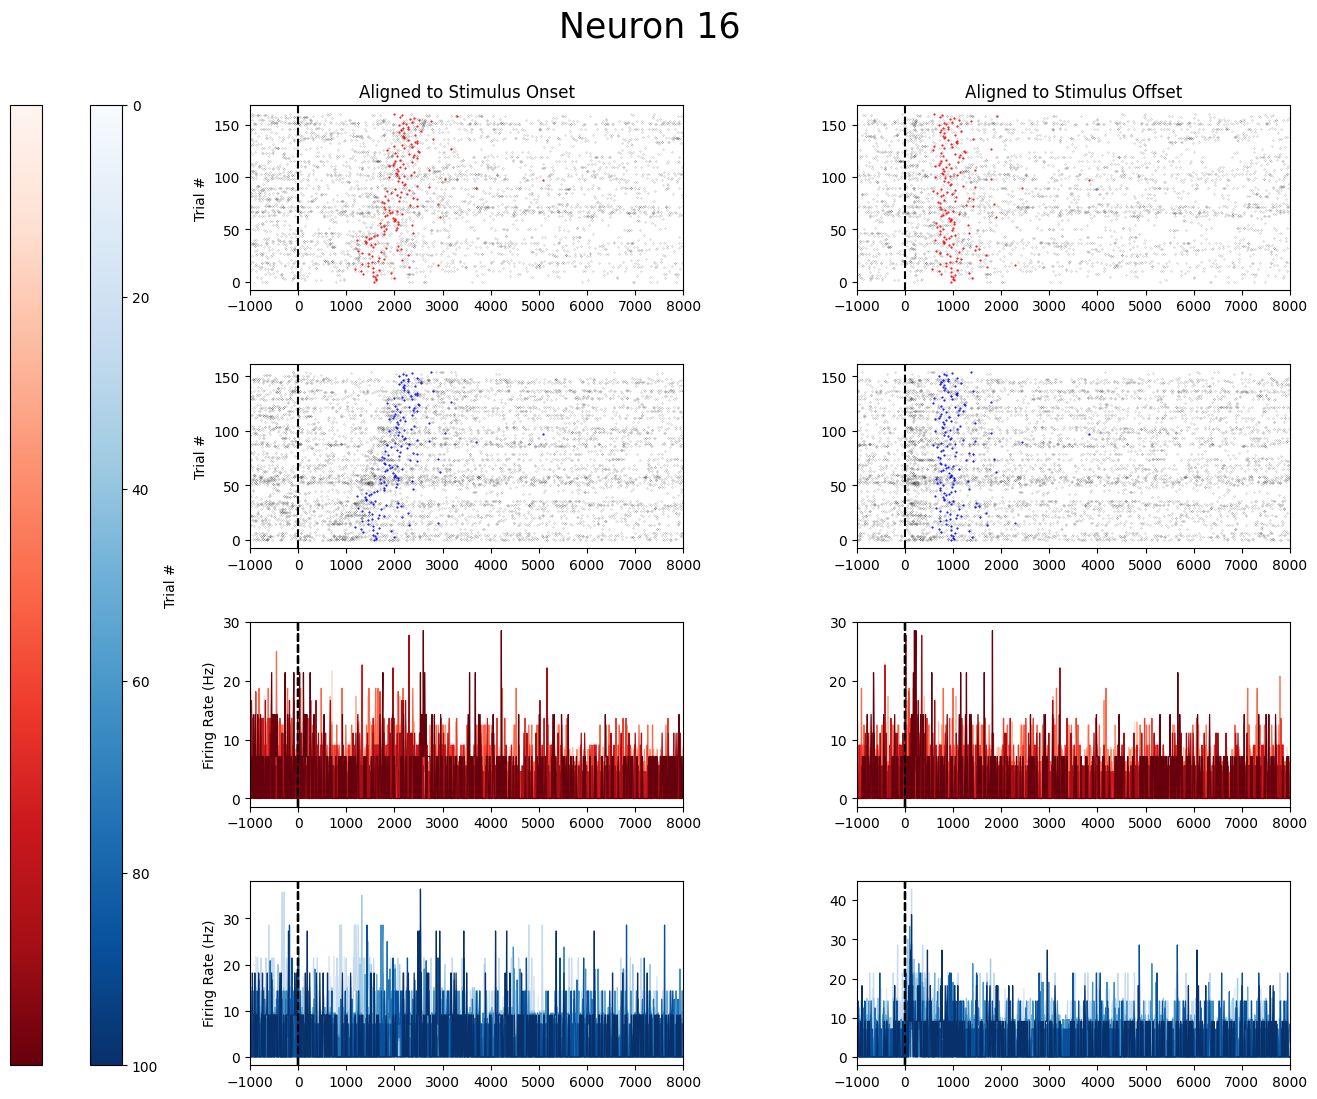

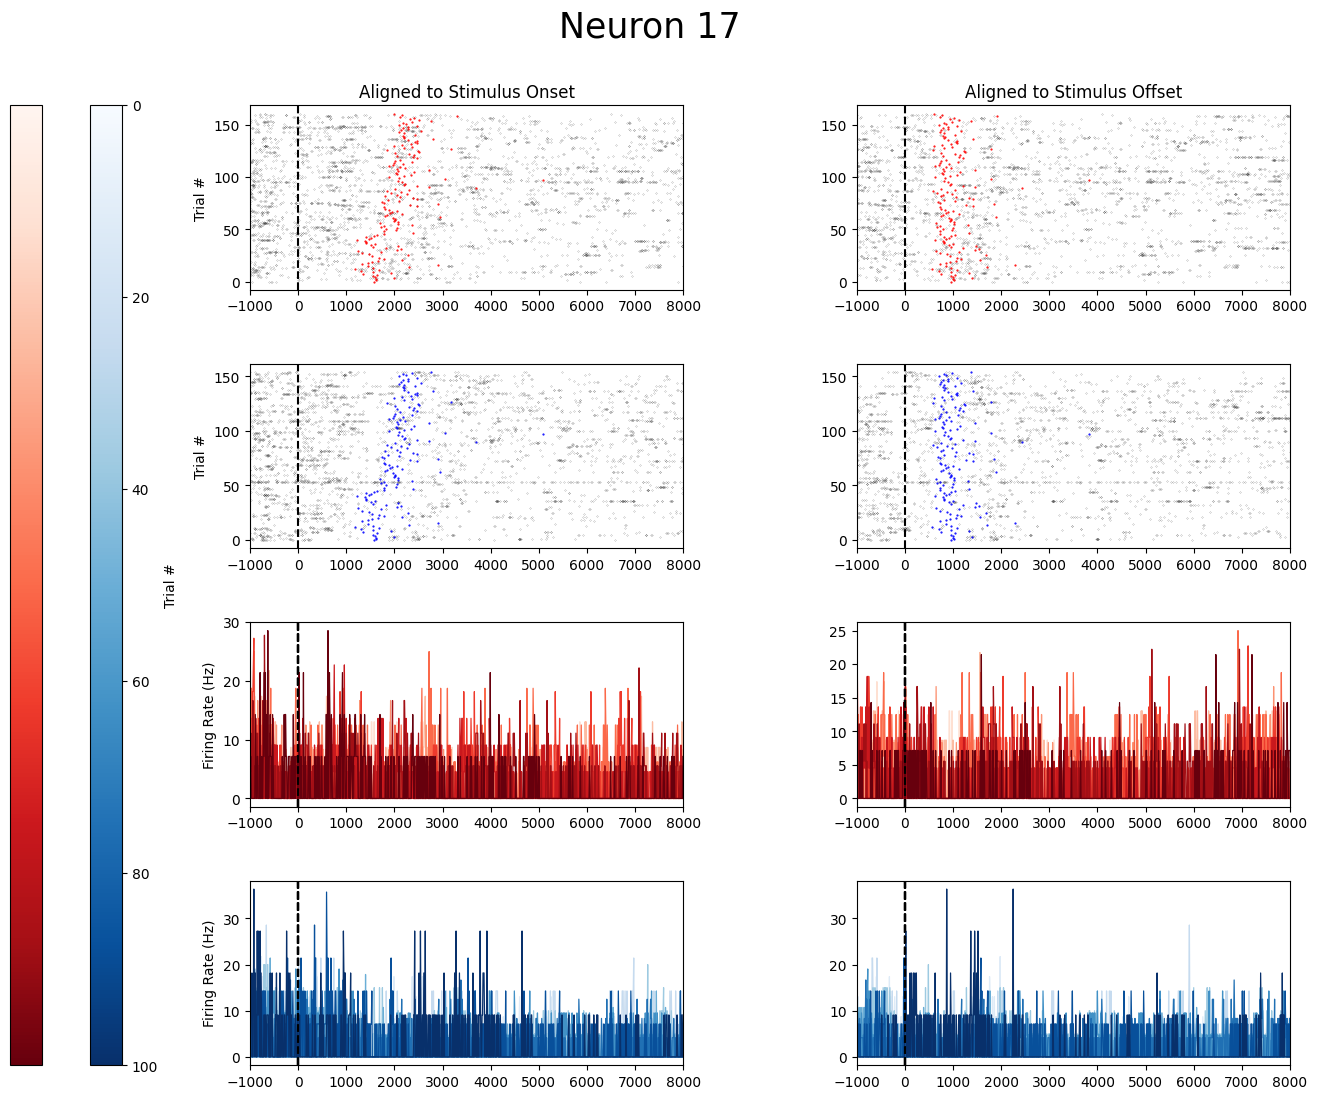

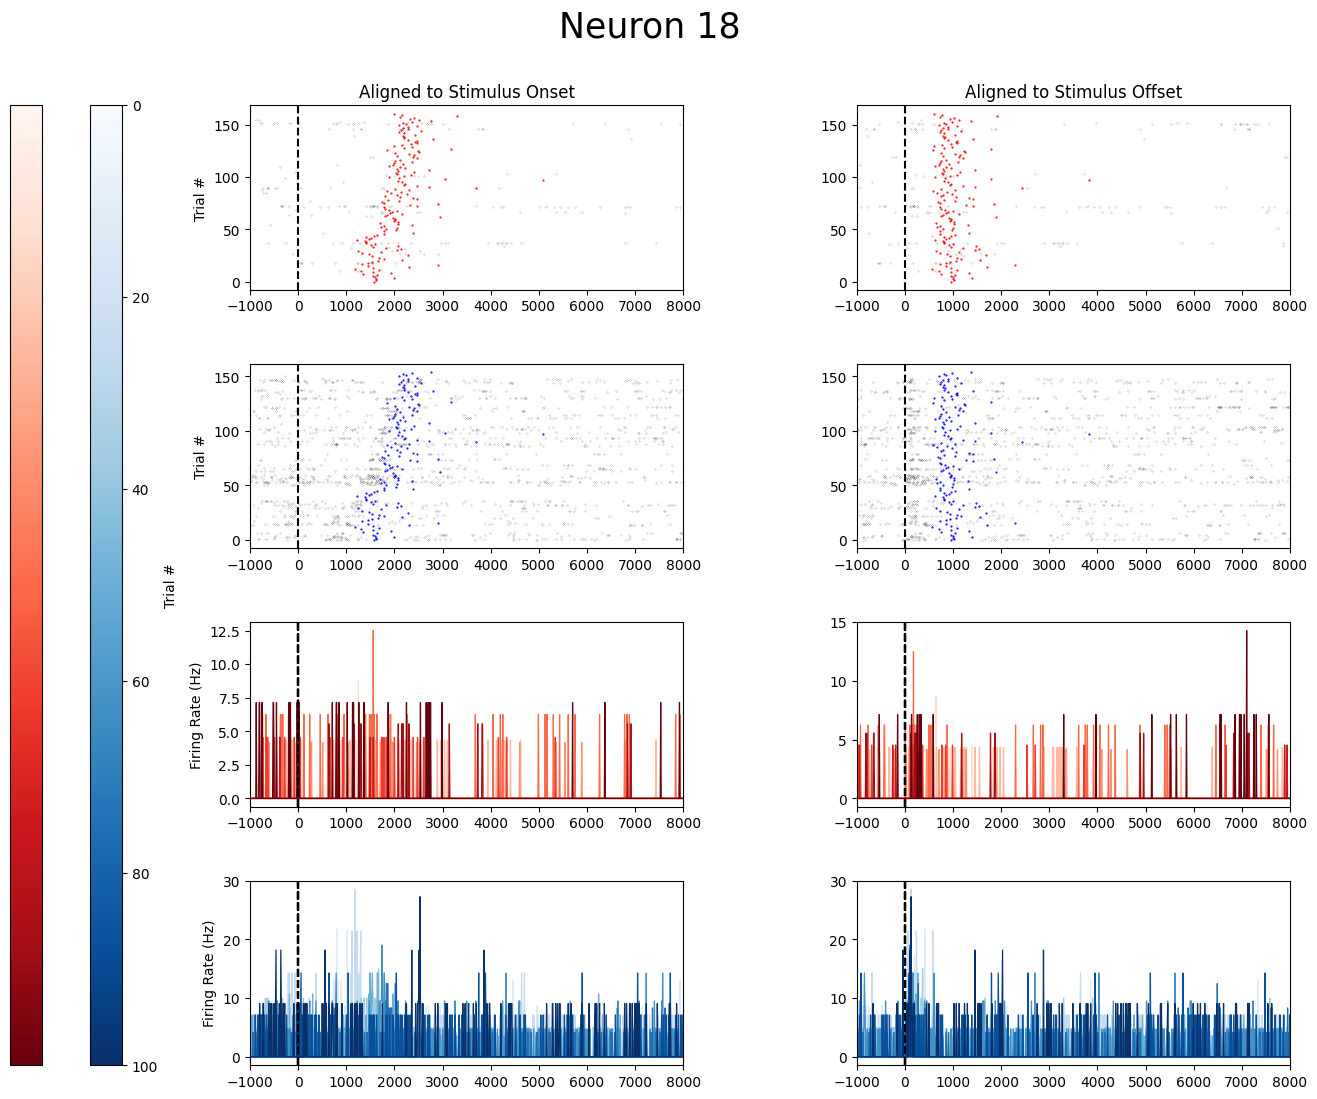

In [18]:
cmap1 = plt.get_cmap('Reds')
norm1 = mcolors.Normalize(vmin=600, vmax=2400)
sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1.set_array([])

cmap2 = plt.get_cmap('Blues')
norm2 = mcolors.Normalize(vmin=0, vmax=100)  
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])

for neuron in np.arange(num_neurons):
    fig, axs = plt.subplots(4, 2, figsize=(16, 12))
    fig.subplots_adjust(left=0.25, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)

    cbar_ax1 = fig.add_axes([0.1, 0.1, 0.02, 0.8])
    cbar1 = plt.colorbar(sm1, cax=cbar_ax1, orientation='vertical')
    cbar1.ax.invert_yaxis()
    cbar1.ax.set_yticks([])

    cbar_ax2 = fig.add_axes([0.15, 0.1, 0.02, 0.8]) 
    cbar2 = plt.colorbar(sm2, cax=cbar_ax2, orientation='vertical')
    cbar2.set_label('Trial #')
    cbar2.ax.invert_yaxis()

    # North Rasters- Onset
    axs[0, 0].scatter(n_onset_spikes[neuron], n_onset_trials[neuron], s = 0.01, color = 'k')
    axs[0, 0].scatter(n_onset_colored_points[neuron], range(N_NUM_TRIALS), s = 0.3, color = 'r') # type: ignore
    axs[0, 0].set_ylabel("Trial #") # type: ignore
    axs[0, 0].set_title(f"Aligned to Stimulus Onset")
    axs[0, 0].axvline(x=0, color="k", ls="--")
    axs[0, 0].set_xlim(window[0], window[1])  

    # North Rasters- Offset
    axs[0, 1].scatter(n_offset_spikes[neuron], n_offset_trials[neuron], s = 0.01, color = 'k')
    axs[0, 1].scatter(n_offset_colored_points[neuron], range(N_NUM_TRIALS), s = 0.3, color = 'r')
    axs[0, 1].set_title(f"Aligned to Stimulus Offset")
    axs[0, 1].axvline(x=0, color="k", ls="--")
    axs[0, 1].set_xlim(window[0], window[1])

    # South Rasters- Onset
    axs[1, 0].scatter(s_onset_spikes[neuron], s_onset_trials[neuron], s = 0.01, color = 'k')
    axs[1, 0].scatter(s_onset_colored_points[neuron], range(S_NUM_TRIALS), s = 0.3, color = 'b')
    axs[1, 0].set_ylabel("Trial #")
    axs[1, 0].axvline(x=0, color="k", ls="--")
    axs[1, 0].set_xlim(window[0], window[1])  

    # South Rasters- Offset
    axs[1, 1].scatter(s_offset_spikes[neuron], s_offset_trials[neuron], s = 0.01, color = 'k')
    axs[1, 1].scatter(s_offset_colored_points[neuron], range(S_NUM_TRIALS), s = 0.3, color = 'b')
    axs[1, 1].axvline(x=0, color="k", ls="--")
    axs[1, 1].set_xlim(window[0], window[1])

    for stim in np.arange(NUM_STIMS):

        # North PSTHs- Onset
        axs[2, 0].plot(bins, n_onset_summed[neuron][stim], color = n_onset_psth_colors[stim], linewidth = 0.9)
        axs[2, 0].axvline(x=0, color="k", ls="--")
        axs[2, 0].set_xlim(window[0], window[1])
        axs[2, 0].set_ylabel('Firing Rate (Hz)')


        # North PSTHs- Offset
        axs[2, 1].plot(bins, n_offset_summed[neuron][stim], color = n_offset_psth_colors[stim], linewidth = 0.9)
        axs[2, 1].axvline(x=0, color="k", ls="--")
        axs[2, 1].set_xlim(window[0], window[1])

        # South PSTHs- Onset
        axs[3, 0].plot(bins, s_onset_summed[neuron][stim], color = s_onset_psth_colors[stim], linewidth = 0.9)
        axs[3, 0].axvline(x=0, color="k", ls="--")
        axs[3, 0].set_xlim(window[0], window[1])
        axs[3, 0].set_ylabel('Firing Rate (Hz)')
        # South PSTHs- Offset
        axs[3, 1].plot(bins, s_offset_summed[neuron][stim], color = s_offset_psth_colors[stim], linewidth = 0.9)
        axs[3, 1].axvline(x=0, color="k", ls="--")
        axs[3, 1].set_xlim(window[0], window[1])

    fig.suptitle(f'Neuron {neuron}', fontsize = 25)


/var/folders/kh/ghd6c8493xb47jcyghc180g80000gn/T/ipykernel_34383/387328210.py:15: RuntimeWarning: invalid value encountered in sqrt
  sqrt_eval = np.sqrt(real_evals)


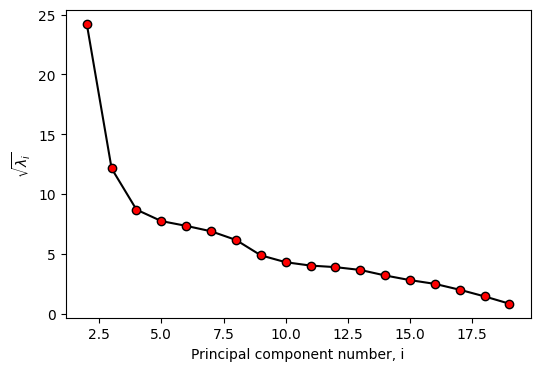

In [19]:
reshaped_bins = []
for neuron in np.arange(NUM_NEURONS):
    og_binned_counts = s_onset_summed[neuron]
    len_spike_train = s_onset_summed[neuron].shape[0] * s_onset_summed[neuron].shape[1]
    reshaped_bins.append(np.reshape(og_binned_counts, (1, len_spike_train)))

X_data = np.vstack(reshaped_bins)
mean_vec = np.mean(X_data, axis=0)
centered_data = X_data - mean_vec

cov_matrix = np.cov(centered_data)

real_evals, real_evecs = np.linalg.eig(cov_matrix)

sqrt_eval = np.sqrt(real_evals)

sorted_indices = np.argsort(sqrt_eval)[::-1]
sorted_eigenvecs = real_evecs[:, sorted_indices]
sqrt_eigvals = sqrt_eval[sorted_indices]

PC_numbers = np.arange(1,num_neurons+1)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(PC_numbers, sqrt_eigvals, c="k", marker="o", mfc="r", mec="k")
ax.set_ylabel(r"$\sqrt{\lambda_i}$")  
ax.set_xlabel("Principal component number, i")
plt.show()

In [20]:
def create_gamma_kernel(kernel_duration, bin_width, shape_param, scale_param):
    kernel_time = np.arange(0, kernel_duration, bin_width) - kernel_duration/2  # Time vector for kernel
    gamma_kern = gamma.pdf(kernel_time, shape_param, scale=scale_param)
    gamma_kern /= np.sum(gamma_kern)  # Normalize kernel
    return gamma_kern

# kernel_duration = (window[1] - window[0]) / 1000  # Duration of the gamma kernel in seconds
kernel_duration = 1  # Duration of the gamma kernel in seconds
# bin_width = BIN_SIZE/1000 # Bin width in seconds
bin_width = 0.002 # Bin width in seconds
peak_gam = .05
shape_param = 2 # Shape parameter (typically between 2 - 5)
scale_param = .03  # Scale parameter (in seconds)
gamma_kernel = create_gamma_kernel(kernel_duration, bin_width, shape_param, scale_param)

def convolve_psth_array(psth_array, gamma_kernel):
    # Convolve each row of PSTH data with the gamma kernel
    smoothed_psth_array = np.zeros_like(psth_array)
    for i in range(psth_array.shape[0]):
        smoothed_psth_array[i, :] = np.convolve(psth_array[i, :], gamma_kernel, mode='same')
    return smoothed_psth_array

def z_score_psth_array(psth_array):
    # Compute the mean and standard deviation for each row
    mean = np.mean(psth_array, axis=1, keepdims=True)
    std_dev = np.std(psth_array, axis=1, keepdims=True)
    
    std_dev = np.where(std_dev == 0, 1, std_dev)
    # Compute the Z-scores
    z_scores_array = (psth_array - mean) / std_dev
    return z_scores_array

In [21]:
times = [0, 600, 1050, 1260, 1380, 1620, 1740, 1950, 2400]
time_idx = []

for time in times:
    index = np.where(bins == time)[0][0]
    time_idx.append(index)

In [22]:
# z_scored_and_smooth = z_score_psth_array(n_onset_raw_bins[10])
def z_scored_and_smooth(raw_binned_data):
    smoothed_and_scored_list = []
    for neuron in np.arange(NUM_NEURONS):
        smoothed = []
        for row in np.arange(raw_binned_data[neuron].shape[0]):
            convolved = np.convolve(raw_binned_data[neuron][row, :], gamma_kernel, mode='same')
            smoothed.append(convolved)
        smoothed = np.stack(smoothed)
        # print(len(smoothed))
        smoothed_and_scored_list.append(z_score_psth_array(smoothed))
    smoothed_and_scored = np.stack(smoothed_and_scored_list)
    return smoothed_and_scored

In [23]:
def stacked_raster_arr(data, cumulative_sums):
    stacked_rasters = []
    for neuron in np.arange(NUM_NEURONS):
        stacked = []
        for stim in np.arange(NUM_STIMS):
            trial_start = cumulative_sums[stim]
            trial_end = cumulative_sums[stim + 1]
            time_start = time_idx[0]
            time_end = time_idx[stim + 1]
            mean = np.mean(data[neuron][trial_start:trial_end], axis = 0)
            
            stacked.append(mean[time_start:time_end])

        stacked_arr = np.hstack(stacked)
        # print(stacked.shape)
        stacked_rasters.append(stacked_arr)
    stacked_raster_arr = np.vstack(stacked_rasters)

    return stacked_raster_arr
    # stacked_rasters.append(stacked)
    # # stacked_rasters.append(stacked)
    # stacked_rasters = np.stack(stacked_rasters)

In [24]:
c_onset_raw_bins, C_NUM_TRIALS, c_onset_psth_colors, c_onset_spikes, c_onset_trials, c_onset_summed, c_onset_colored_points = rasters_and_psths(color= 'Purples', data= stim_onset_t, data_points= choice_rt, num_neurons= NUM_NEURONS, window= window, BIN_SIZE= BIN_SIZE, new_sorted_trials= new_sorted_trials, cumulative_sum_list= cumulative_sum_list)

In [25]:
n_smoothed_and_scored = z_scored_and_smooth(n_onset_raw_bins)
n_stacked_rasters = stacked_raster_arr(data= n_smoothed_and_scored, cumulative_sums= n_cumulative_sum)
s_smoothed_and_scored = z_scored_and_smooth(s_onset_raw_bins)
s_stacked_rasters = stacked_raster_arr(data= s_smoothed_and_scored, cumulative_sums= s_cumulative_sum)
c_smoothed_and_scored = z_scored_and_smooth(c_onset_raw_bins)
c_ind_stacked_rasters = stacked_raster_arr(data= c_smoothed_and_scored, cumulative_sums= cumulative_sum_list)
cond_dependent = (np.hstack((n_stacked_rasters, s_stacked_rasters))) - (np.hstack((c_ind_stacked_rasters, c_ind_stacked_rasters)))

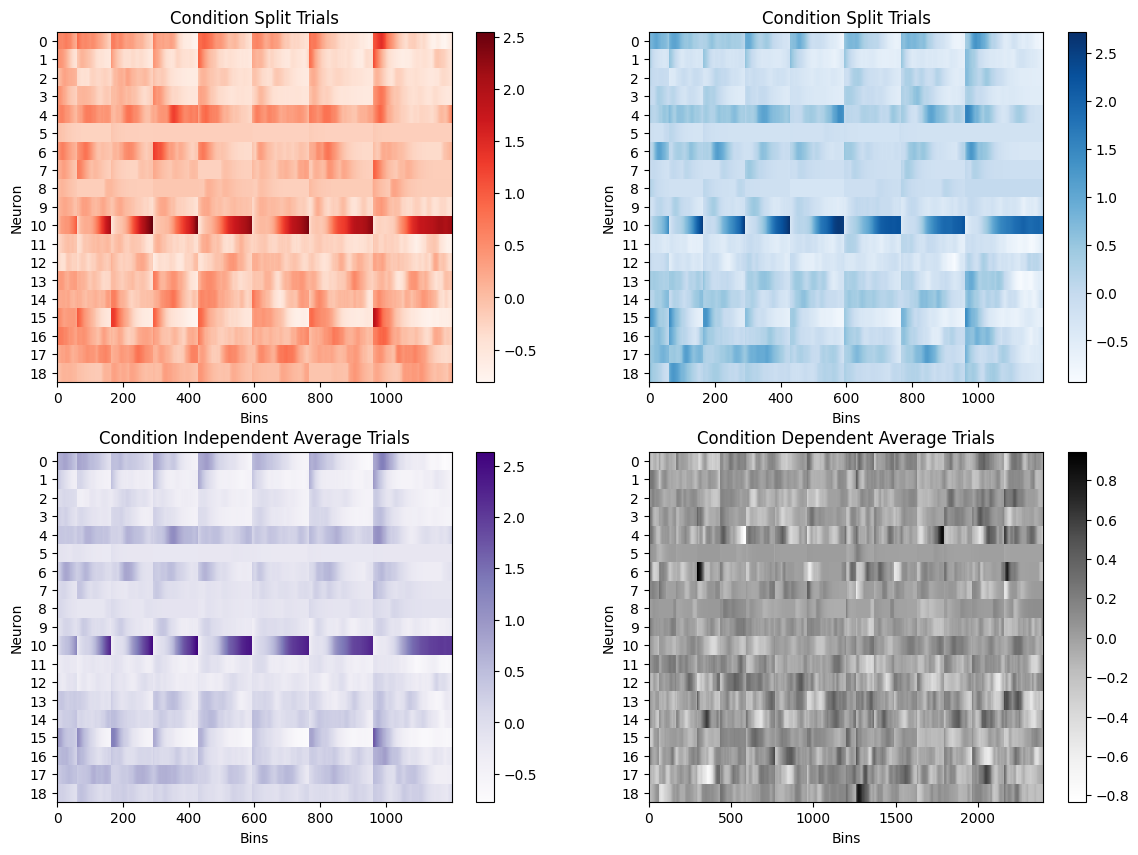

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

cax1 = axs[0,0].imshow(n_stacked_rasters, aspect='auto', cmap='Reds', interpolation='nearest')
axs[0,0].set_xlabel('Bins')
axs[0,0].set_ylabel('Neuron');
axs[0,0].set_title('Condition Split Trials');
yticks = np.arange(n_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(n_stacked_rasters.shape[0])];
axs[0,0].set_yticks(yticks, yticklabels);
fig.colorbar(cax1, ax=axs[0, 0]);

cax2 = axs[0,1].imshow(s_stacked_rasters, aspect='auto', cmap='Blues', interpolation='nearest')
axs[0,1].set_xlabel('Bins')
axs[0,1].set_ylabel('Neuron');
axs[0,1].set_title('Condition Split Trials');
yticks = np.arange(n_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(n_stacked_rasters.shape[0])];
axs[0,1].set_yticks(yticks, yticklabels);
fig.colorbar(cax2, ax=axs[0, 1]);

cax3 = axs[1,0].imshow(c_ind_stacked_rasters, aspect='auto', cmap='Purples', interpolation='nearest')
axs[1,0].set_xlabel('Bins')
axs[1,0].set_ylabel('Neuron');
axs[1,0].set_title('Condition Independent Average Trials');
yticks = np.arange(n_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(n_stacked_rasters.shape[0])];
axs[1,0].set_yticks(yticks, yticklabels);
fig.colorbar(cax3, ax=axs[1, 0]);

cax4 = axs[1,1].imshow(cond_dependent, aspect='auto', cmap='Greys', interpolation='nearest')
axs[1,1].set_xlabel('Bins')
axs[1,1].set_ylabel('Neuron');
axs[1,1].set_title('Condition Dependent Average Trials');
yticks = np.arange(n_stacked_rasters.shape[0]);
yticklabels = [f'{i}' for i in np.arange(n_stacked_rasters.shape[0])];
axs[1,1].set_yticks(yticks, yticklabels);
fig.colorbar(cax4, ax=axs[1,1]);

In [275]:
c_ind_stacked_rasters_T = c_ind_stacked_rasters.T
mu = np.mean(c_ind_stacked_rasters_T, axis = 0)

CI_cov = np.cov(c_ind_stacked_rasters_T, rowvar= False)

# These are going to be the shape of the number of bins/trials
CI_evals, CI_evecs = np.linalg.eigh(CI_cov)

sorted_idx = np.argsort(CI_evals)[::-1]
CI_evals = CI_evals[sorted_idx]
CI_evecs = CI_evecs[:, sorted_idx]

u3 = CI_evecs[:, :3]
OG_points = np.dot(c_ind_stacked_rasters_T, u3)

In [295]:
times_arr = np.array(times)/BIN_SIZE
start = 0
proj_N_per_trial = []
proj_S_per_trial = []

N_cmap = plt.get_cmap('Reds')
intervals = np.arange(60, 300, 30)
N_colors = N_cmap(intervals) 

S_cmap = plt.get_cmap('Blues')
S_colors = S_cmap(intervals) 

for idx in np.arange(NUM_STIMS):
    start += int(times_arr[idx])
    N_start = start
    bin_bw = times_arr[idx + 1]
    N_end = int(N_start + bin_bw)
    S_start = N_start + int(cond_dependent.shape[1]/2)
    S_end = int(S_start + bin_bw)
    
    proj_N = np.dot(cond_dependent.T[:][N_start:N_end], u3)
    proj_S = np.dot(cond_dependent.T[:][S_start:S_end], u3)
    proj_N_per_trial.append(proj_N)
    proj_S_per_trial.append(proj_S)

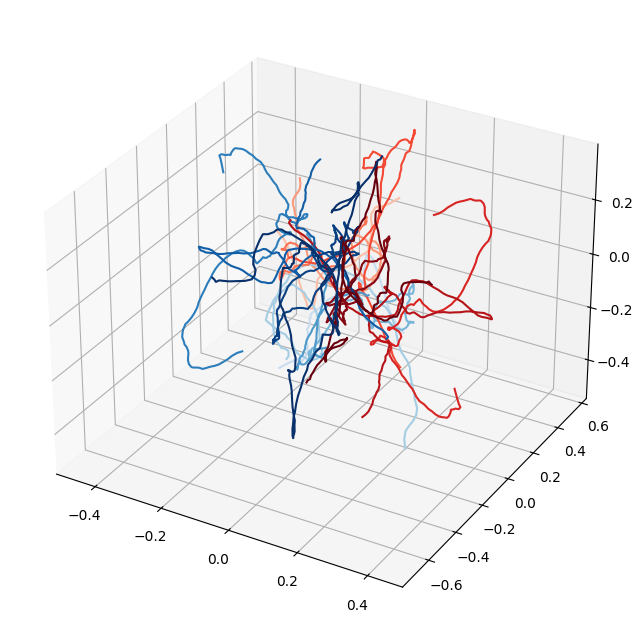

In [359]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
for stim in np.arange(NUM_STIMS):
    ax.plot(proj_N_per_trial[stim][:,0], proj_N_per_trial[stim][:,1], proj_N_per_trial[stim][:,2], color = N_colors[stim])
    ax.plot(proj_S_per_trial[stim][:,0], proj_S_per_trial[stim][:,1], proj_S_per_trial[stim][:,2], color = S_colors[stim])


In [389]:
proj_N_per_trial[0][:, 0].shape[0]

60

In [434]:
def PC_plots(N_S, cmap_color, title):
    fig, ax = plt.subplots(1, 3, figsize = (24, 4));
    for stim in range(NUM_STIMS):
        y_1 = N_S[stim][:, 0]
        y_2 = N_S[stim][:, 1]
        y_3 = N_S[stim][:, 2]
        x = np.arange(0, y_1.shape[0], 1)
        ax[0].plot(x, y_1, color = cmap_color[stim])
        ax[0].plot(x[-1], y_1[-1], 'o', color=cmap_color[stim])
        ax[1].plot(x, y_2, color = cmap_color[stim])
        ax[1].plot(x[-1], y_2[-1], 'o', color=cmap_color[stim])
        ax[2].plot(x, y_3, color = cmap_color[stim])
        ax[2].plot(x[-1], y_3[-1], 'o', color=cmap_color[stim])

        ax[0].set_xlabel('Time');
        ax[0].set_ylabel('PC 1');
        ax[1].set_xlabel('Time');
        ax[1].set_ylabel('PC 2');
        ax[2].set_xlabel('Time');
        ax[2].set_ylabel('PC 3');
    
    fig.suptitle(f'{title}');


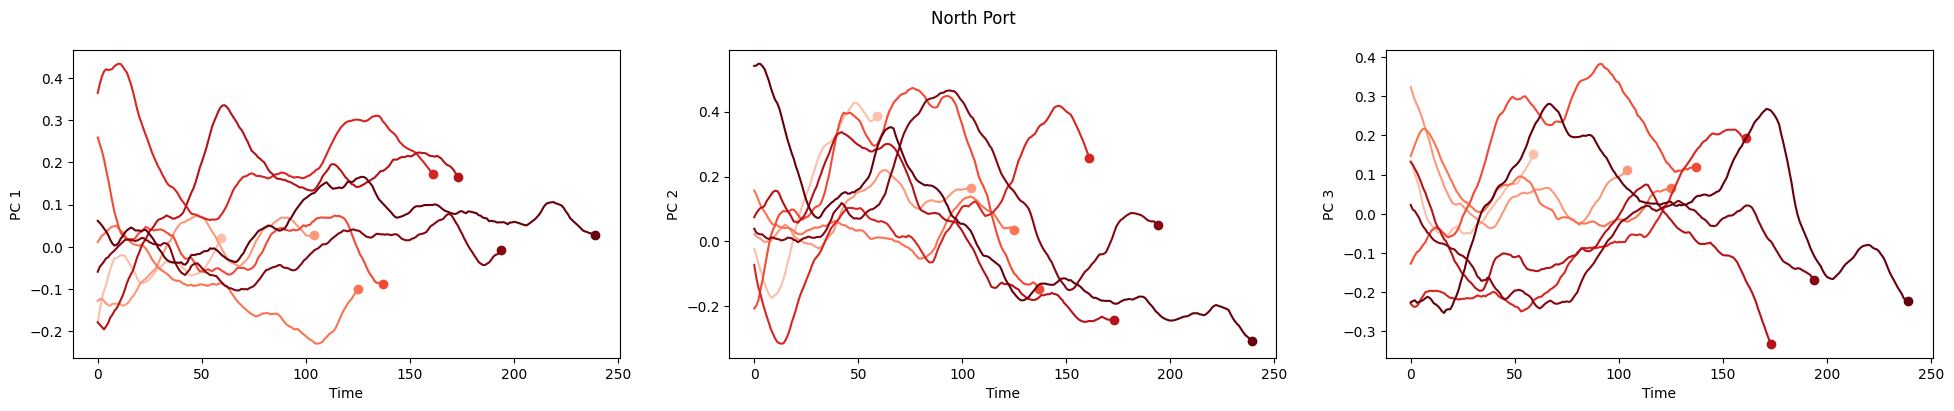

<Figure size 640x480 with 0 Axes>

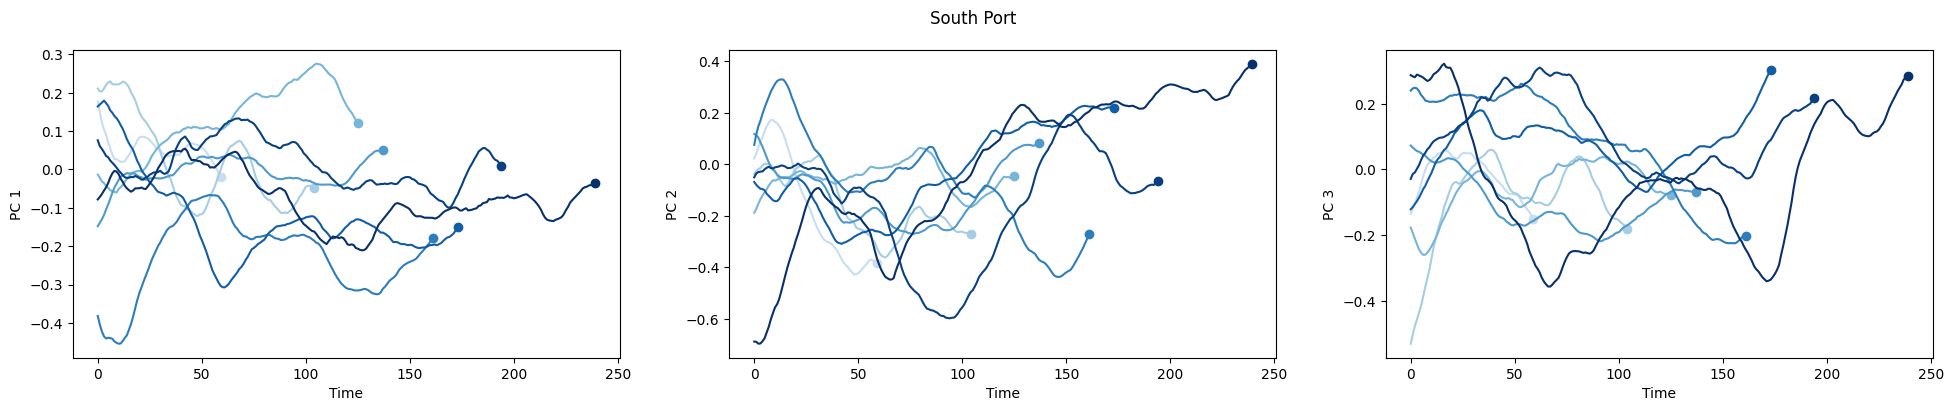

In [435]:
PC_plots(proj_N_per_trial, N_colors, 'North Port')
plt.figure()
PC_plots(proj_S_per_trial, S_colors, 'South Port')

In [437]:
n_smoothed_and_scored.shape

(19, 162, 900)